### This notebook produces the jet plots that are in the "Tools for Unbinned Unfolding" paper
### This notebook assumes the data is stored in h5 files and that the unfolding models (PET, DNN, BDTs) are already trained
### You can change the paths to the data and models in the first few cells

In [1]:
import numpy as np
import ROOT
import pandas as pd
import matplotlib.pyplot as plt
import modplot
from omnifold import DataLoader, MLP, MultiFold, PET
import h5py as h5
import pickle
import gzip
import gc

2025-03-06 10:12:31.800996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-06 10:12:31.801037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 10:12:31.802226: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 10:12:31.808453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-06 10:12:32.375654: W tensorflow/compiler/tf2

Horovod instalation found.


No protocol specified
No protocol specified
2025-03-06 10:12:33.649827: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-06 10:12:33.650266: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-06 10:12:33.687150: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/D

#### Parameters for the plots

In [2]:
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rc('legend', fontsize=10)
plt.rc('font', size=10)
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

#### Choosing which models to use
#### If the make_predictions variables are True, the model will be opened and make live predictions on the data
#### If make_predictions are False and load_predictions are True, saved predictions will be loaded from a file
#### One of these must be true if the use_model variable is True
#### The adjustable paths are in the second cell below

In [3]:
num_iterations = 5

use_unifold_BDT = True
make_unifold_BDT_predictions = True
load_unifold_BDT_weights = False
save_unifold_BDT_weights = False

use_multifold_BDT = True
make_multifold_BDT_predictions = True
load_multifold_BDT_weights = False
save_multifold_BDT_weights = False

use_DNN = True
make_DNN_predictions = False
load_DNN_weights = True
save_DNN_weights = False

use_PET = True
make_PET_predictions = False
load_PET_weights = True
save_PET_weights = False

use_binned_BDT = True
train_binned_BDT = False
load_binned_BDT_weights = True
save_binned_BDT_weights = False

In [4]:
if use_unifold_BDT:
    if make_unifold_BDT_predictions:
        unifold_model_path = "/home/ryan/unfolding_paper/unfolding/final_BDT_models/"
        unifold_model_name = "BDT_unifold_5iterations"
    elif load_unifold_BDT_weights:
        unifold_BDT_weights_file = "./"
    else:
        raise ValueError("Must either make predictions or load predictions if using the Unifold BDT!")

    if save_unifold_BDT_weights:
        unifold_BDT_save_path = "./"
        
if use_multifold_BDT:
    if make_multifold_BDT_predictions:
        multifold_model_path = "/home/ryan/unfolding_paper/unfolding/final_BDT_models/"
        multifold_model_name = "BDT_multifold_5iterations"
    elif load_multifold_BDT_weights:
        multifold_BDT_weights_file = ""
    else:
        raise ValueError("Must either make predictions or load predictions if using the Multifold BDT!")

    if save_multifold_BDT_weights:
        multifold_BDT_save_path = "./"
        
if use_DNN:
    if make_DNN_predictions:
        DNN_model_path = f"/home/ryan/unfolding_paper/unfolding/final_weights/OmniFold_DNN_5iterations_fullstats_iter{num_iterations-1}_step2.weights.h5"
    elif load_DNN_weights:
        DNN_weights_file = "/home/ryan/unfolding_paper/unfolding/saved_DNN_weights_5iters.pickle.gz"
    else:
        raise ValueError("Must either make predictions or load predictions if using the DNN!")

    if save_DNN_weights:
        DNN_save_path = "./"
        
if use_PET:
    if make_PET_predictions:
        PET_model_path = f"/home/ryan/unfolding_paper/unfolding/final_weights/OmniFold_OmniFold_PET_5its_iter{num_iterations-1}_step2.weights.h5"
    elif load_PET_weights:
        PET_weights_file = "/home/ryan/unfolding_paper/unfolding/saved_PET_weights_5iters.pickle.gz"
    else:
        raise ValueError("Must either make predictions or load predictions if using the PET!")  

    if save_PET_weights:
        PET_save_path = "./"

if use_binned_BDT:
    if load_binned_BDT_weights:
        binned_BDT_weights_path = "/home/ryan/unfolding_paper/unfolding/final_BDT_models/"
    elif not train_binned_BDT:
        raise ValueError("Must either train the BDT or load the weights for binned BDT unfolding!")
    if save_binned_BDT_weights:
        binned_BDT_save_path = "./"

### Loading the data
#### The train files have 1.2 million events, the test files have about 400k

In [5]:
num_train_data = -1
num_test_data = -1

data_dir = "/media/miguel/Elements_2024/unfolding_data/Z+jets/"
synthetic_file_path = data_dir + "train_pythia.h5"
nature_file_path = data_dir + "train_herwig.h5"

synthetic_test_file_path = data_dir + "test_pythia.h5"
nature_test_file_path = data_dir + "test_herwig.h5"

In [6]:
synthetic  =  h5.File(synthetic_file_path, 'r')
nature = h5.File(nature_file_path, 'r')
synthetic_test  =  h5.File(synthetic_test_file_path, 'r')
nature_test = h5.File(nature_test_file_path, 'r')
obs_multifold = ['Mass', 'Mult', 'Width', 'Tau21', 'zg', 'SDMass']

In [7]:
synthetic_obs = {'gen_mass':synthetic['gen_subs'][:num_train_data, 0], 'gen_width':synthetic['gen_subs'][:num_train_data, 1], 'gen_mult':synthetic['gen_subs'][:num_train_data, 2],
                 'gen_sdmass':synthetic['gen_subs'][:num_train_data, 3], 'gen_zg':synthetic['gen_subs'][:num_train_data, 4], 'gen_tau21':synthetic['gen_subs'][:num_train_data, 5],
                 'reco_mass':synthetic['reco_subs'][:num_train_data, 0], 'reco_width':synthetic['reco_subs'][:num_train_data, 1], 'reco_mult':synthetic['reco_subs'][:num_train_data, 2],
                 'reco_sdmass':synthetic['reco_subs'][:num_train_data, 3], 'reco_zg':synthetic['reco_subs'][:num_train_data, 4], 'reco_tau21':synthetic['reco_subs'][:num_train_data, 5]}
nature_obs    = {'gen_mass':nature['gen_subs'][:num_train_data, 0], 'gen_width':nature['gen_subs'][:num_train_data, 1], 'gen_mult':nature['gen_subs'][:num_train_data, 2],
                 'gen_sdmass':nature['gen_subs'][:num_train_data, 3], 'gen_zg':nature['gen_subs'][:num_train_data, 4], 'gen_tau21':nature['gen_subs'][:num_train_data, 5],
                 'reco_mass':nature['reco_subs'][:num_train_data, 0], 'reco_width':nature['reco_subs'][:num_train_data, 1], 'reco_mult':nature['reco_subs'][:num_train_data, 2],
                 'reco_sdmass':nature['reco_subs'][:num_train_data, 3], 'reco_zg':nature['reco_subs'][:num_train_data, 4], 'reco_tau21':nature['reco_subs'][:num_train_data, 5]}
synthetic_pass_reco = (synthetic['reco_jets'][:num_train_data,0]>150)
nature_pass_reco = (nature['reco_jets'][:num_train_data,0]>150)

In [8]:
synthetic_test_obs = {'gen_mass':synthetic_test['gen_subs'][:num_test_data, 0], 'gen_width':synthetic_test['gen_subs'][:num_test_data, 1], 'gen_mult':synthetic_test['gen_subs'][:num_test_data, 2],
                 'gen_sdmass':synthetic_test['gen_subs'][:num_test_data, 3], 'gen_zg':synthetic_test['gen_subs'][:num_test_data, 4], 'gen_tau21':synthetic_test['gen_subs'][:num_test_data, 5],
                 'reco_mass':synthetic_test['reco_subs'][:num_test_data, 0], 'reco_width':synthetic_test['reco_subs'][:num_test_data, 1], 'reco_mult':synthetic_test['reco_subs'][:num_test_data, 2],
                 'reco_sdmass':synthetic_test['reco_subs'][:num_test_data, 3], 'reco_zg':synthetic_test['reco_subs'][:num_test_data, 4], 'reco_tau21':synthetic_test['reco_subs'][:num_test_data, 5]}
nature_test_obs   = {'gen_mass':nature_test['gen_subs'][:num_test_data, 0], 'gen_width':nature_test['gen_subs'][:num_test_data, 1], 'gen_mult':nature_test['gen_subs'][:num_test_data, 2],
                 'gen_sdmass':nature_test['gen_subs'][:num_test_data, 3], 'gen_zg':nature_test['gen_subs'][:num_test_data, 4], 'gen_tau21':nature_test['gen_subs'][:num_test_data, 5],
                 'reco_mass':nature_test['reco_subs'][:num_test_data, 0], 'reco_width':nature_test['reco_subs'][:num_test_data, 1], 'reco_mult':nature_test['reco_subs'][:num_test_data, 2],
                 'reco_sdmass':nature_test['reco_subs'][:num_test_data, 3], 'reco_zg':nature_test['reco_subs'][:num_test_data, 4], 'reco_tau21':nature_test['reco_subs'][:num_test_data, 5]}
synthetic_test_pass_reco = (synthetic_test['reco_jets'][:num_test_data,0]>150)
nature_test_pass_reco = (nature_test['reco_jets'][:num_test_data,0]>150)

In [9]:
# a dictionary to hold information about the observables
obs, obs_test = {}, {}

# the jet mass and histogram style information
obs.setdefault('Mass', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_mass'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 75), 'ylim': (0, 0.065),
    'xlabel': r'Jet Mass $m$ [GeV]', 'symbol': r'$m$',
    'ylabel': r'Normalized Cross Section [GeV$^{-1}$]',
    'stamp_xy': (0.425, 0.6),
})

# the constituent multiplicity and histogram style information
obs.setdefault('Mult', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_mult'],
    'nbins_det': 80, 'nbins_mc': 80,
    'xlim': (0, 80), 'ylim': (0, 0.065),
    'xlabel': 'Jet Constituent Multiplicity $M$', 'symbol': r'$M$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.44, 0.6),
})

# the jet width and histogram style information
obs.setdefault('Width', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_width'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.6), 'ylim': (0, 10),
    'xlabel': r'Jet Width $w$', 'symbol': r'$w$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.425, 0.6),
})

# the N-subjettiness ratio and histogram style information
obs.setdefault('Tau21', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_tau21'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 1.2), 'ylim': (0, 3),
    'xlabel': r'$N$-subjettiness Ratio $\tau_{21}^{(\beta=1)}$', 'symbol': r'$\tau_{21}^{(\beta=1)}$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# the groomed momentum fraction and histogram style information
obs.setdefault('zg', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_zg'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.5), 'ylim': (0, 9),
    'xlabel': r'Groomed Jet Momentum Fraction $z_g$', 'symbol': r'$z_g$',
    'ylabel': 'Normalized Cross Section',
    'stamp_xy': (0.425, 0.6),
})

# the groomed jet mass and histogram style information
obs.setdefault('SDMass', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_sdmass'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (-14, -2), 'ylim': (0, 0.3),
    'xlabel': r'Soft Drop Jet Mass $\ln\rho$', 'symbol': r'$\ln\rho$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# the jet mass and histogram style information
obs_test.setdefault('Mass', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_mass'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 75), 'ylim': (0, 0.065),
    'xlabel': r'Jet Mass $m$ [GeV]', 'symbol': r'$m$',
    'ylabel': r'Normalized Cross Section [GeV$^{-1}$]',
    'stamp_xy': (0.425, 0.6),
})

# the constituent multiplicity and histogram style information
obs_test.setdefault('Mult', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_mult'],
    'nbins_det': 80, 'nbins_mc': 80,
    'xlim': (0, 80), 'ylim': (0, 0.065),
    'xlabel': 'Jet Constituent Multiplicity $M$', 'symbol': r'$M$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.44, 0.6),
})

# the jet width and histogram style information
obs_test.setdefault('Width', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_width'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.6), 'ylim': (0, 10),
    'xlabel': r'Jet Width $w$', 'symbol': r'$w$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.425, 0.6),
})

# the N-subjettiness ratio and histogram style information
obs_test.setdefault('Tau21', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_tau21'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 1.2), 'ylim': (0, 3),
    'xlabel': r'$N$-subjettiness Ratio $\tau_{21}^{(\beta=1)}$', 'symbol': r'$\tau_{21}^{(\beta=1)}$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# the groomed momentum fraction and histogram style information
obs_test.setdefault('zg', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_zg'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.5), 'ylim': (0, 9),
    'xlabel': r'Groomed Jet Momentum Fraction $z_g$', 'symbol': r'$z_g$',
    'ylabel': 'Normalized Cross Section',
    'stamp_xy': (0.425, 0.6),
})

# the groomed jet mass and histogram style information
obs_test.setdefault('SDMass', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_sdmass'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (-14, -2), 'ylim': (0, 0.3),
    'xlabel': r'Soft Drop Jet Mass $\ln\rho$', 'symbol': r'$\ln\rho$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})


# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Truth"'}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
dnn_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}
PET_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:purple', 'zorder': 3}
bdt_multifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:orange', 'zorder': 3}
bdt_binned_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:purple', 'zorder': 3}
bdt_unifold_unbinned_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:blue', 'zorder': 3}

In [10]:
# calculate quantities to be stored in obs
for obkey,ob in obs.items():
    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic_obs, 'gen'), ob['func'](synthetic_obs, 'reco')
    ob['truthobs'], ob['dataobs'] = ob['func'](nature_obs, 'gen'), ob['func'](nature_obs, 'reco')
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]
    
    print('Done with', obkey)

Done with Mass
Done with Mult
Done with Width
Done with Tau21
Done with zg
Done with SDMass


In [11]:
# calculate quantities to be stored in obs test
for obkey,ob in obs_test.items():

    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic_test_obs, 'gen'), ob['func'](synthetic_test_obs, 'reco')
    ob['truthobs'], ob['dataobs'] = ob['func'](nature_test_obs, 'gen'), ob['func'](nature_test_obs, 'reco')
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'][nature_test_pass_reco], bins=ob['bins_det'], density=True)[0]
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]
    
    print('Done with', obkey)

Done with Mass
Done with Mult
Done with Width
Done with Tau21
Done with zg
Done with SDMass


#### Functions that will be used during DNN/PET predictions

In [12]:
def expit(x):
    return 1. / (1. + np.exp(-x))
def reweight(events,model,batch_size=None):
    f = expit(model.predict(events,batch_size=batch_size))
    weights = f / (1. - f)  # this is the crux of the reweight, approximates likelihood ratio
    weights = np.nan_to_num(weights[:,0],posinf=1)
    return weights

#### Loading PET results if used

In [13]:
if use_PET:
    if make_PET_predictions:
        synthtic_gen_parts_test = synthetic_test['gen'][:num_test_data]
        normalized_MC_gen = (synthtic_gen_parts_test - np.mean(synthtic_gen_parts_test, axis=0))/np.std(synthtic_gen_parts_test, axis=0)
        
        synthetic_PET_model = PET(
            synthetic_gen_parts.shape[2],
            num_part=synthetic_gen_parts.shape[1],
            num_heads = 4,
            num_transformer = 4,
            local = True,
            projection_dim = 128,
            K = 10
        )

        print("Making PET predictions")
        synthetic_PET_model.load_weights(PET_path)
        PET_step2_weights = reweight(normalized_MC_gen, synthetic_PET_model, batch_size=1000)
    elif load_PET_weights:
        print("Loading PET weights")
        with gzip.open(PET_weights_file, 'rb') as f:
            PET_data = pickle.load(f)
        PET_step2_weights = PET_data['PET_weights']

    if save_PET_weights:
        data_to_save = {"PET_weights": PET_step2_weights}
        output_file = PET_save_path
        with gzip.open(output_file, 'wb') as f:
            pickle.dump(data_to_save, f)

Loading PET weights


#### Loading DNN predictions if used

In [14]:
if use_DNN:
    if make_DNN_predictions:
        MC_gen_test = np.asarray([obs_test[obkey]['genobs'] for obkey in obs_multifold]).T
        normalized_MC_gen_test = (MC_gen_test - np.mean(MC_gen_test, axis=0))/np.std(MC_gen_test, axis=0)

        ndim = len(obs_multifold) #The number of features present in your dataset
        synthetic_DNN_model = MLP(ndim)
        
        print("Making DNN predictions")
        synthetic_DNN_model.load_weights(DNN_path)
        DNN_step2_weights = reweight(normalized_MC_gen_test, synthetic_DNN_model, batch_size=1000)
    elif load_DNN_weights:
        print("Loading DNN weights")
        with gzip.open(DNN_weights_file, 'rb') as f:
            DNN_data = pickle.load(f)
        DNN_step2_weights = DNN_data['DNN_weights']

    if save_DNN_weights:
        data_to_save = {"DNN_weights": DNN_step2_weights}
        output_file = DNN_save_path
        with gzip.open(output_file, 'wb') as f:
            pickle.dump(data_to_save, f)

Loading DNN weights


#### Setting up data for BDT unfolding

In [15]:
mc_entries = np.asarray([(obs[obkey]['genobs']) for obkey in obs_multifold]).T
sim_entries = np.asarray([(obs[obkey]['simobs']) for obkey in obs_multifold]).T
measured_entries = np.asarray([(obs[obkey]['dataobs']) for obkey in obs_multifold]).T
pass_truth_mask = np.full(len(sim_entries), True)

mc_entries_test = np.asarray([(obs_test[obkey]['genobs']) for obkey in obs_multifold]).T
sim_entries_test = np.asarray([(obs_test[obkey]['simobs']) for obkey in obs_multifold]).T
measured_entries_test = np.asarray([(obs_test[obkey]['dataobs']) for obkey in obs_multifold]).T
pass_truth_mask_test = np.full(len(sim_entries_test), True)

mc_entries_all = np.concatenate((mc_entries, mc_entries_test))
sim_entries_all = np.concatenate((sim_entries, sim_entries_test))
synthetic_pass_reco_all = np.concatenate((synthetic_pass_reco, synthetic_test_pass_reco))
measured_entries_all = np.concatenate((measured_entries, measured_entries_test))
measured_pass_reco_all = np.concatenate((nature_pass_reco, nature_test_pass_reco))

In [16]:
def np_to_TVector(array):
    vector = ROOT.TVector(len(array))
    for i, entry in enumerate(array):
        vector[i] = entry
    return vector
def TVector_to_np(vector):
    num_entries = vector.GetNoElements()
    np_array = np.empty([num_entries, ], dtype = np.float32)
    for i in range(num_entries):
        np_array[i] = vector[i]
    return np_array

#### Loading Multifold BDT if used

In [17]:
# Creating just one RooUnfoldOmnifold object and changing out the data in it
if use_multifold_BDT or use_unifold_BDT:
    unfolding_bdt = ROOT.RooUnfoldOmnifold()

In [18]:
if use_multifold_BDT:
    if make_multifold_BDT_predictions:
        # Converting the data to a RDataframe for the BDTs
        df_MCgen_multi_test = ROOT.RDF.FromNumpy({name: mc_entries_test[:, i] for i, name in enumerate(obs_multifold)})
        df_MCreco_multi_test = ROOT.RDF.FromNumpy({name: sim_entries_test[:, i] for i, name in enumerate(obs_multifold)})
        MC_pass_reco_vector_test = np_to_TVector(synthetic_test_pass_reco)
        
        print("Making multifold BDT predictions")
        unfolding_bdt.SetSaveDirectory(multifold_model_path)
        unfolding_bdt.SetModelName(multifold_model_name)
        unfolding_bdt.SetTestMCgenDataFrame(df_MCgen_multi_test)
        unfolding_bdt.SetTestMCrecoDataFrame(df_MCreco_multi_test)
        unfolding_bdt.SetTestMCPassReco(MC_pass_reco_vector_test)
        multifold_bdt_results = unfolding_bdt.TestUnbinnedOmnifold()
        multifold_bdt_step1_weights_TVector = ROOT.std.get[0](multifold_bdt_results)
        multifold_bdt_step2_weights_TVector = ROOT.std.get[1](multifold_bdt_results)
        multifold_bdt_step1_weights = TVector_to_np(multifold_bdt_step1_weights_TVector)
        multifold_bdt_step2_weights = TVector_to_np(multifold_bdt_step2_weights_TVector)

        # Deleting the ROOT objects so they don't keep getting created in each loop
        del df_MCgen_multi_test, df_MCreco_multi_test, MC_pass_reco_vector_test, multifold_bdt_results, multifold_bdt_step1_weights_TVector, multifold_bdt_step2_weights_TVector
        gc.collect()
    elif load_multifold_BDT_weights:
        print("Loading multifold BDT weights")
        with gzip.open(multifold_BDT_weights_file, 'rb') as f:
            multifold_BDT_data = pickle.load(f)
        multifold_bdt_step2_weights = multifold_BDT_data['multifold_BDT_weights']

    if save_multifold_BDT_weights:
        data_to_save = {"multifold_BDT_weights": multifold_bdt_step2_weights}
        output_file = multifold_BDT_save_path
        with gzip.open(output_file, 'wb') as f:
            pickle.dump(data_to_save, f)

Making multifold BDT predictions
Opening /home/ryan/unfolding_paper/unfolding/final_BDT_models/BDT_multifold_5iterations_models.pkl for step 1 predictions.
Opening /home/ryan/unfolding_paper/unfolding/final_BDT_models/BDT_multifold_5iterations_models.pkl for step 2 predictions.


In [19]:
if use_unifold_BDT:
    if make_unifold_BDT_predictions:
        unifold_bdt_step2_weights = []
        MC_pass_reco_vector_test = np_to_TVector(synthetic_test_pass_reco)
        for i, obs_name in enumerate(obs_multifold):
            df_MCgen_single = ROOT.RDF.FromNumpy({obs_multifold[i]: mc_entries_test[:, i]})
            df_MCreco_single = ROOT.RDF.FromNumpy({obs_multifold[i]: sim_entries_test[:, i]})
            df_measured_single = ROOT.RDF.FromNumpy({obs_multifold[i]: measured_entries[:, i]})

            print("Making unifold BDT predictions")
            unfolding_bdt.SetSaveDirectory(unifold_model_path)
            unfolding_bdt.SetModelName(f"{unifold_model_name}_{obs_name}")
            unfolding_bdt.SetTestMCgenDataFrame(df_MCgen_single)
            unfolding_bdt.SetTestMCrecoDataFrame(df_MCreco_single)
            unfolding_bdt.SetTestMCPassReco(MC_pass_reco_vector_test)
            unifold_bdt_results = unfolding_bdt.TestUnbinnedOmnifold()
            unifold_bdt_step1_weights_TVector = ROOT.std.get[0](unifold_bdt_results)
            unifold_bdt_step2_weights_TVector = ROOT.std.get[1](unifold_bdt_results)
            unifold_bdt_step1_weights_obs = TVector_to_np(unifold_bdt_step1_weights_TVector)
            unifold_bdt_step2_weights_obs = TVector_to_np(unifold_bdt_step2_weights_TVector)
            unifold_bdt_step2_weights.append(unifold_bdt_step2_weights_obs)
            del df_MCgen_single, df_MCreco_single, df_measured_single, unifold_bdt_results, unifold_bdt_step1_weights_TVector, unifold_bdt_step2_weights_TVector
            gc.collect()
    elif load_unifold_BDT_weights:
        print("Loading unifold BDT weights")
        with gzip.open(unifold_BDT_weights_file, 'rb') as f:
            unifold_BDT_data = pickle.load(f)
        unifold_bdt_step2_weights = multifold_BDT_data['unifold_BDT_weights']

    if save_unifold_BDT_weights:
        data_to_save = {"unifold_BDT_weights": unifold_bdt_step2_weights}
        output_file = unifold_BDT_save_path
        with gzip.open(output_file, 'wb') as f:
            pickle.dump(data_to_save, f)

Making unifold BDT predictions
Opening /home/ryan/unfolding_paper/unfolding/final_BDT_models/BDT_unifold_5iterations_Mass_models.pkl for step 1 predictions.
Opening /home/ryan/unfolding_paper/unfolding/final_BDT_models/BDT_unifold_5iterations_Mass_models.pkl for step 2 predictions.
Making unifold BDT predictions
Opening /home/ryan/unfolding_paper/unfolding/final_BDT_models/BDT_unifold_5iterations_Mult_models.pkl for step 1 predictions.
Opening /home/ryan/unfolding_paper/unfolding/final_BDT_models/BDT_unifold_5iterations_Mult_models.pkl for step 2 predictions.
Making unifold BDT predictions
Opening /home/ryan/unfolding_paper/unfolding/final_BDT_models/BDT_unifold_5iterations_Width_models.pkl for step 1 predictions.
Opening /home/ryan/unfolding_paper/unfolding/final_BDT_models/BDT_unifold_5iterations_Width_models.pkl for step 2 predictions.
Making unifold BDT predictions
Opening /home/ryan/unfolding_paper/unfolding/final_BDT_models/BDT_unifold_5iterations_Tau21_models.pkl for step 1 pred

### Binning the data for IBU and binned BDT unfolding (if used)

In [20]:
sim_data_mass, sim_data_width, sim_data_mult, sim_data_lnrho, sim_data_zgs, sim_data_tau21 = [], [], [], [], [], []
mc_data_mass, mc_data_width, mc_data_mult, mc_data_lnrho, mc_data_zgs, mc_data_tau21 = [], [], [], [], [], []
meas_data_mass, meas_data_width, meas_data_mult, meas_data_lnrho, meas_data_zgs, meas_data_tau21 = [], [], [], [], [], []

for i in range(len(measured_entries_all)):
    meas_data_mass.append(measured_entries_all[i][0])
    meas_data_mult.append(measured_entries_all[i][1])
    meas_data_width.append(measured_entries_all[i][2])
    meas_data_tau21.append(measured_entries_all[i][3])
    meas_data_zgs.append(measured_entries_all[i][4])
    meas_data_lnrho.append(measured_entries_all[i][5])
    
for i in range(len(mc_entries_all)):
    mc_data_mass.append(mc_entries_all[i][0])
    mc_data_mult.append(mc_entries_all[i][1])
    mc_data_width.append(mc_entries_all[i][2])
    mc_data_tau21.append(mc_entries_all[i][3])
    mc_data_zgs.append(mc_entries_all[i][4])
    mc_data_lnrho.append(mc_entries_all[i][5])
for i in range(len(sim_entries_all)):
    sim_data_mass.append(sim_entries_all[i][0])
    sim_data_mult.append(sim_entries_all[i][1])
    sim_data_width.append(sim_entries_all[i][2])
    sim_data_tau21.append(sim_entries_all[i][3])
    sim_data_zgs.append(sim_entries_all[i][4])
    sim_data_lnrho.append(sim_entries_all[i][5])


#Binned Data
bins_mass, bin_low_mass, bin_high_mass = obs['Mass']['nbins_det'], obs['Mass']['xlim'][0], obs['Mass']['xlim'][1]
bins_widths, bin_low_widths, bin_high_widths  = obs['Width']['nbins_det'], obs['Width']['xlim'][0], obs['Width']['xlim'][1]
bins_mult, bin_low_mult, bin_high_mult  = obs['Mult']['nbins_det'], obs['Mult']['xlim'][0], obs['Mult']['xlim'][1]
bins_lnrho, bin_low_lnrho, bin_high_lnrho  = obs['SDMass']['nbins_det'], obs['SDMass']['xlim'][0], obs['SDMass']['xlim'][1]
bins_zgs, bin_low_zgs, bin_high_zgs  = obs['zg']['nbins_det'], obs['zg']['xlim'][0], obs['zg']['xlim'][1]
bins_tau21, bin_low_tau21, bin_high_tau21  = obs['Tau21']['nbins_det'], obs['Tau21']['xlim'][0], obs['Tau21']['xlim'][1]

meas_data_mass_binned = ROOT.TH1D("meas_mass_hist", "meas_mass_hist", bins_mass, bin_low_mass, bin_high_mass)
meas_data_width_binned = ROOT.TH1D("meas_width_hist", "meas_width_hist", bins_widths, bin_low_widths, bin_high_widths)
meas_data_mult_binned = ROOT.TH1D("meas_mult_hist", "meas_mult_hist", bins_mult, bin_low_mult, bin_high_mult)
meas_data_lnrho_binned = ROOT.TH1D("meas_lnrho_hist", "meas_lnrho_hist", bins_lnrho, bin_low_lnrho, bin_high_lnrho)
meas_data_zgs_binned = ROOT.TH1D("meas_zgs_hist", "meas_zgs_hist", bins_zgs, bin_low_zgs, bin_high_zgs)
meas_data_tau21_binned = ROOT.TH1D("meas_tau21_hist", "meas_tau21_hist", bins_tau21, bin_low_tau21, bin_high_tau21)

response_mass = ROOT.RooUnfoldResponse(bins_mass, bin_low_mass, bin_high_mass, bins_mass, bin_low_mass, bin_high_mass)
response_width = ROOT.RooUnfoldResponse(bins_widths, bin_low_widths, bin_high_widths, bins_widths, bin_low_widths, bin_high_widths)
response_mult = ROOT.RooUnfoldResponse(bins_mult, bin_low_mult, bin_high_mult, bins_mult, bin_low_mult, bin_high_mult)
response_lnrho = ROOT.RooUnfoldResponse(bins_lnrho, bin_low_lnrho, bin_high_lnrho, bins_lnrho, bin_low_lnrho, bin_high_lnrho)
response_zgs = ROOT.RooUnfoldResponse(bins_zgs, bin_low_zgs, bin_high_zgs, bins_zgs, bin_low_zgs, bin_high_zgs)
response_tau21 = ROOT.RooUnfoldResponse(bins_tau21, bin_low_tau21, bin_high_tau21, bins_tau21, bin_low_tau21, bin_high_tau21)

In [21]:
#Unbinned data and fill response matrices
def build_data(
        response, 
        initial_mc_list, 
        initial_sim_list,
        synthetic_pass_reco,
        initial_measured_list,
        nature_pass_reco,
        measured_hist, 
    ):
    for (sim, MC, pass_reco) in zip(initial_sim_list, initial_mc_list, synthetic_pass_reco):
        if pass_reco:
            response.Fill(sim, MC)
        else:
            response.Miss(MC)
    for measured in np.asarray(initial_measured_list)[nature_pass_reco]:
        measured_hist.Fill(measured)
    return response, measured_hist

response_mass, meas_data_mass_binned = build_data(
    response_mass,
    mc_data_mass,
    sim_data_mass,
    synthetic_pass_reco_all,
    meas_data_mass,
    measured_pass_reco_all,
    meas_data_mass_binned
)

response_mult, meas_data_mult_binned = build_data(
    response_mult,
    mc_data_mult,
    sim_data_mult,
    synthetic_pass_reco_all,
    meas_data_mult,
    measured_pass_reco_all,
    meas_data_mult_binned
)

response_width, meas_data_width_binned = build_data(
    response_width,
    mc_data_width,
    sim_data_width,
    synthetic_pass_reco_all,
    meas_data_width,
    measured_pass_reco_all,
    meas_data_width_binned
)

response_tau21, meas_data_tau21_binned = build_data(
    response_tau21,
    mc_data_tau21,
    sim_data_tau21,
    synthetic_pass_reco_all,
    meas_data_tau21,
    measured_pass_reco_all,
    meas_data_tau21_binned
)

response_zgs, meas_data_zgs_binned = build_data(
    response_zgs,
    mc_data_zgs,
    sim_data_zgs,
    synthetic_pass_reco_all,
    meas_data_zgs,
    measured_pass_reco_all,
    meas_data_zgs_binned
)

response_lnrho, meas_data_lnrho_binned = build_data(
    response_lnrho,
    mc_data_lnrho,
    sim_data_lnrho,
    synthetic_pass_reco_all,
    meas_data_lnrho,
    measured_pass_reco_all,
    meas_data_lnrho_binned
)

In [22]:
IBU_mass = ROOT.RooUnfoldBayes(response_mass, meas_data_mass_binned, num_iterations)
h_mass_ibu = IBU_mass.Hunfold()
IBU_mult = ROOT.RooUnfoldBayes(response_mult, meas_data_mult_binned, num_iterations)
h_mult_ibu = IBU_mult.Hunfold()
IBU_width = ROOT.RooUnfoldBayes(response_width, meas_data_width_binned, num_iterations)
h_width_ibu = IBU_width.Hunfold()
IBU_tau21 = ROOT.RooUnfoldBayes(response_tau21, meas_data_tau21_binned, num_iterations)
h_tau21_ibu = IBU_tau21.Hunfold()
IBU_zg = ROOT.RooUnfoldBayes(response_zgs, meas_data_zgs_binned, num_iterations)
h_zg_ibu = IBU_zg.Hunfold()
IBU_SDMass = ROOT.RooUnfoldBayes(response_lnrho, meas_data_lnrho_binned, num_iterations)
h_SDMass_ibu = IBU_SDMass.Hunfold()
ibu_hist_dict = {"Mass":h_mass_ibu,
                 "Mult":h_mult_ibu,
                 "Width":h_width_ibu,
                 "Tau21":h_tau21_ibu,
                 "zg":h_zg_ibu,
                 "SDMass":h_SDMass_ibu}
for i, (obkey,ob) in enumerate(obs.items()):
    histogram = ibu_hist_dict[obkey]
    bin_centers = [histogram.GetBinCenter(bin) for bin in range(1, histogram.GetNbinsX() + 1)]
    counts = [histogram.GetBinContent(bin) for bin in range(1, histogram.GetNbinsX() + 1)]
    bin_edges = [histogram.GetBinLowEdge(bin) for bin in range(1, histogram.GetNbinsX() + 2)]
    bin_errors = [histogram.GetBinError(bin) for bin in range(1, histogram.GetNbinsX() + 1)]
    
    # Calculate the density-normalized histogram using np.histogram
    density_counts, _ = np.histogram(bin_centers, bins=bin_edges, weights=counts, density=True)
    bin_errors = bin_errors/(np.sum(counts)*(bin_edges[1]-bin_edges[0]))
    # Save counts, errors, and bin centers
    ob['ibu'], ob['ibu_unc'], ob['ibu_bincenters'] = density_counts, bin_errors, bin_centers
# Same thing as previous loop but putting things in obs_test, which will be used during plotting
for i, (obkey,ob) in enumerate(obs_test.items()):
    histogram = ibu_hist_dict[obkey]
    bin_centers = [histogram.GetBinCenter(bin) for bin in range(1, histogram.GetNbinsX() + 1)]
    counts = [histogram.GetBinContent(bin) for bin in range(1, histogram.GetNbinsX() + 1)]
    bin_edges = [histogram.GetBinLowEdge(bin) for bin in range(1, histogram.GetNbinsX() + 2)]
    bin_errors = [histogram.GetBinError(bin) for bin in range(1, histogram.GetNbinsX() + 1)]
    
    # Calculate the density-normalized histogram using np.histogram
    density_counts, _ = np.histogram(bin_centers, bins=bin_edges, weights=counts, density=True)
    bin_errors = bin_errors/(np.sum(counts)*(bin_edges[1]-bin_edges[0]))
    # Save counts, errors, and bin centers
    ob['ibu'], ob['ibu_unc'], ob['ibu_bincenters'] = density_counts, bin_errors, bin_centers

Using response matrix priors
Priors:

Vector (50)  is as follows

     |        1  |
------------------
   0 |8.5368e-05 
   1 |0.000289269 
   2 |0.00147091 
   3 |0.00552804 
   4 |0.0151304 
   5 |0.0307792 
   6 |0.0491302 
   7 |0.0650289 
   8 |0.0757632 
   9 |0.0801544 
  10 |0.080604 
  11 |0.076951 
  12 |0.0717232 
  13 |0.0648355 
  14 |0.0574305 
  15 |0.0499593 
  16 |0.0427067 
  17 |0.0362095 
  18 |0.0303585 
  19 |0.0255244 
  20 |0.0215195 
  21 |0.0179832 
  22 |0.0151464 
  23 |0.0127143 
  24 |0.0107975 
  25 |0.00915464 
  26 |0.00779182 
  27 |0.00669003 
  28 |0.00573931 
  29 |0.00486966 
  30 |0.00426656 
  31 |0.00346877 
  32 |0.0029799 
  33 |0.00252419 
  34 |0.00221895 
  35 |0.00189775 
  36 |0.00163182 
  37 |0.00139844 
  38 |0.00120007 
  39 |0.00101029 
  40 |0.000899128 
  41 |0.000826043 
  42 |0.000649779 
  43 |0.000611087 
  44 |0.000514665 
  45 |0.000483342 
  46 |0.000377707 
  47 |0.000353755 
  48 |0.000331645 
  49 |0.000287426 

Now unfo

In [23]:
if use_binned_BDT:
    if train_binned_BDT:
        BDT_binned_mass = ROOT.RooUnfoldOmnifold(response_mass, meas_data_mass_binned, 1)
        h_mass_BDT_binned = BDT_binned_mass.Hunfold()
        BDT_binned_mult = ROOT.RooUnfoldOmnifold(response_mult, meas_data_mult_binned, 1)
        h_mult_BDT_binned = BDT_binned_mult.Hunfold()
        BDT_binned_width = ROOT.RooUnfoldOmnifold(response_width, meas_data_width_binned, 1)
        h_width_BDT_binned = BDT_binned_width.Hunfold()
        BDT_binned_tau21 = ROOT.RooUnfoldOmnifold(response_tau21, meas_data_tau21_binned, 1)
        h_tau21_BDT_binned = BDT_binned_tau21.Hunfold()
        BDT_binned_zg = ROOT.RooUnfoldOmnifold(response_zgs, meas_data_zgs_binned, 1)
        h_zg_BDT_binned = BDT_binned_zg.Hunfold()
        BDT_binned_SDMass = ROOT.RooUnfoldOmnifold(response_lnrho, meas_data_lnrho_binned, 1)
        h_SDMass_BDT_binned = BDT_binned_SDMass.Hunfold()
        
        BDT_binned_hist_dict = {"Mass":h_mass_BDT_binned,
                                "Mult":h_mult_BDT_binned,
                                "Width":h_width_BDT_binned,
                                "Tau21":h_tau21_BDT_binned,
                                "zg":h_zg_BDT_binned,
                                "SDMass":h_SDMass_BDT_binned
                               }
        for i, (obkey,ob) in enumerate(obs.items()):
            histogram = BDT_binned_hist_dict[obkey]
            bin_centers = [histogram.GetBinCenter(bin) for bin in range(1, histogram.GetNbinsX() + 1)]
            counts = [histogram.GetBinContent(bin) for bin in range(1, histogram.GetNbinsX() + 1)]
            bin_edges = [histogram.GetBinLowEdge(bin) for bin in range(1, histogram.GetNbinsX() + 2)]
            bin_errors = [histogram.GetBinError(bin) for bin in range(1, histogram.GetNbinsX() + 1)]
            
            # Calculate the density-normalized histogram using np.histogram
            density_counts, _ = np.histogram(bin_centers, bins=bin_edges, weights=counts, density=True)
            bin_errors = bin_errors/(np.sum(counts)*(bin_edges[1]-bin_edges[0]))
            # Save counts, errors, and bin centers
            ob['binned_BDT'], ob['binned_BDT_unc'], ob['binned_BDT_bincenters'] = density_counts, bin_errors, bin_centers
            obs_test[obkey]['binned_BDT'], obs_test[obkey]['binned_BDT_unc'], obs_test[obkey]['binned_BDT_bincenters'] = density_counts, bin_errors, bin_centers
            if save_binned_BDT_weights:
                data_to_save = {"binned_BDT" : ob['binned_BDT'], "binned_BDT_unc" : ob['binned_BDT_unc'], "binned_BDT_bincenters" : ob['binned_BDT_bincenters']}
                output_file = f"{binned_BDT_save_path}saved_binnedBDT_weights_{obkey}.pickle.gz"
                with gzip.open(output_file, 'wb') as f:
                    pickle.dump(data_to_save, f)
    elif load_binned_BDT_weights:
        for obkey,ob in obs_test.items():
            with gzip.open(f'{binned_BDT_weights_path}/saved_binnedBDT_weights_{obkey}.pickle.gz', 'rb') as f:
                loaded_data = pickle.load(f)
                ob['binned_BDT'] = loaded_data['binned_BDT']
                ob['binned_BDT_unc'] = loaded_data['binned_BDT_unc']
                ob['binned_BDT_bincenters'] = loaded_data['binned_BDT_bincenters']

In [24]:
draw_data = True
draw_sim = True
draw_mc = True
draw_truth = True

draw_IBU = True

draw_DNN = True
if not use_DNN:
    draw_DNN = False
    
draw_PET = True
if not use_PET:
    draw_PET = False

draw_multifold_BDT = True
if not use_multifold_BDT:
    draw_multifold_BDT = False

draw_unifold_BDT = True
if not use_unifold_BDT:
    draw_unifold_BDT = False
    
draw_binned_BDT = False
if not use_binned_BDT:
    draw_binned_BDT = False

truth_fill = True

### Making the plots using the test data

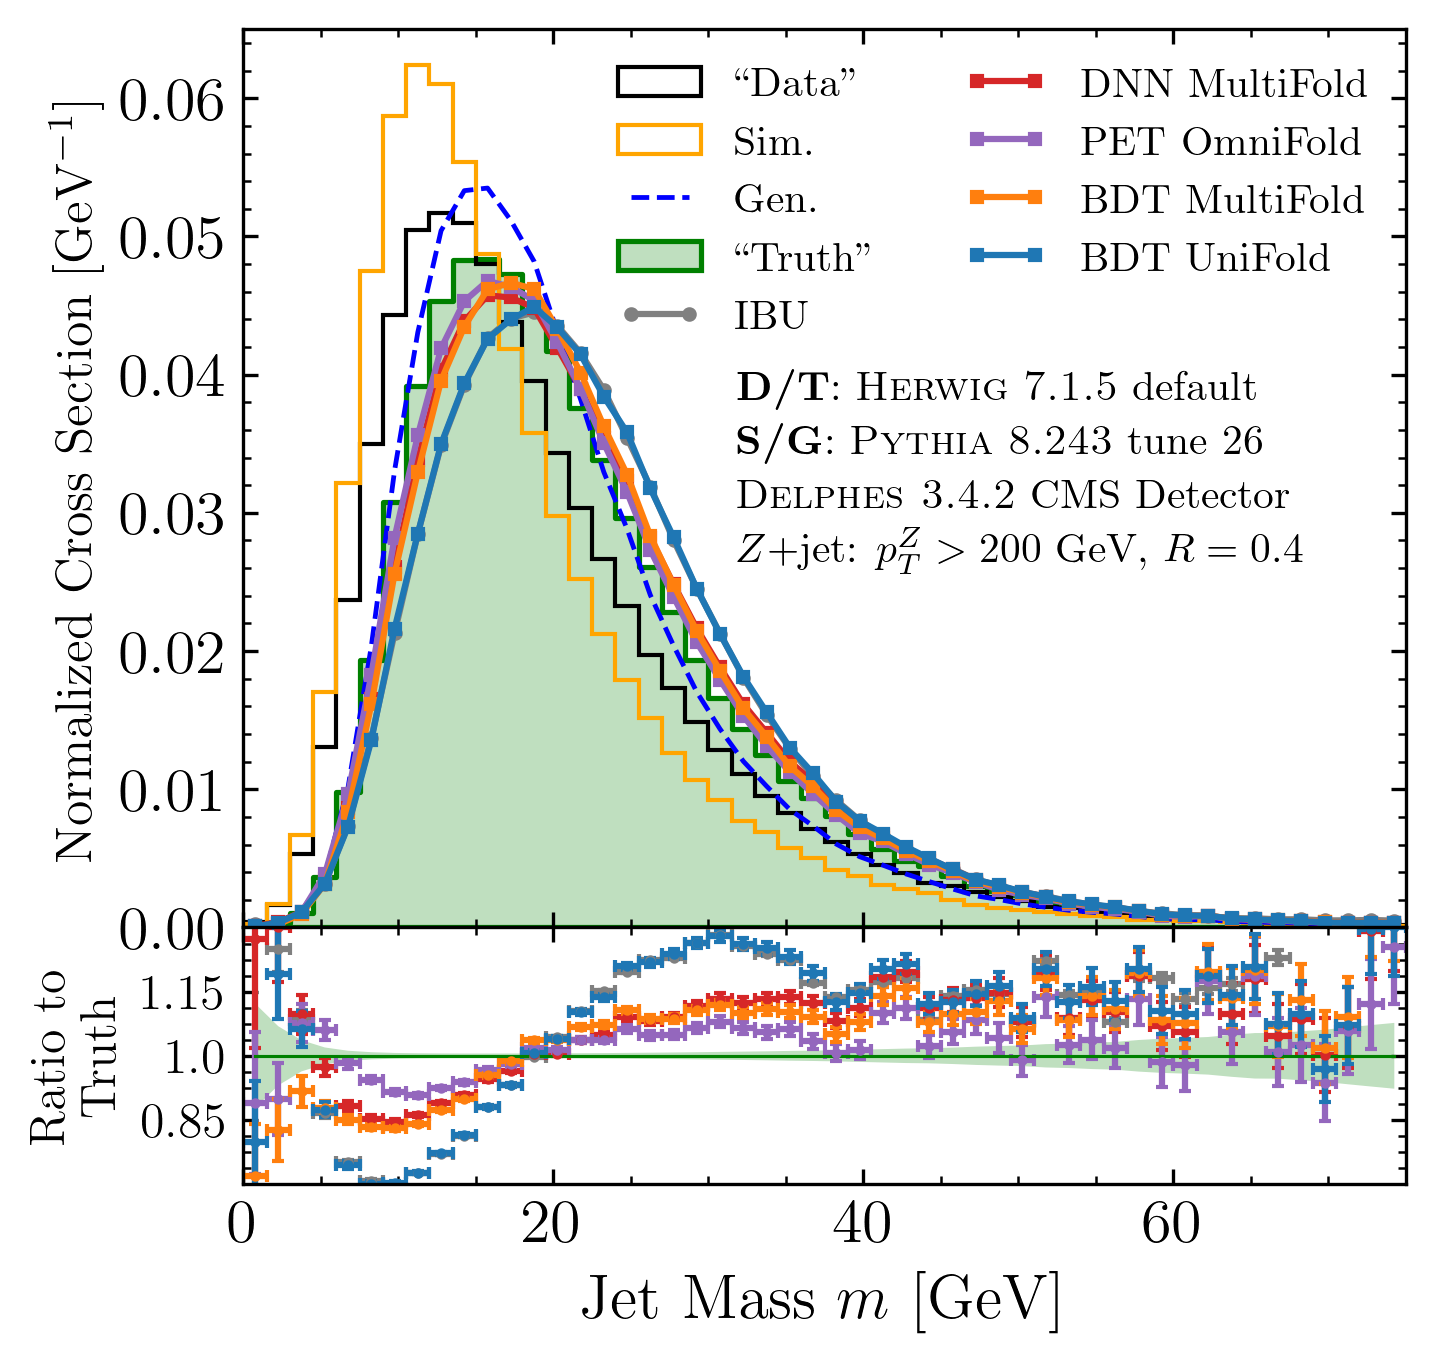

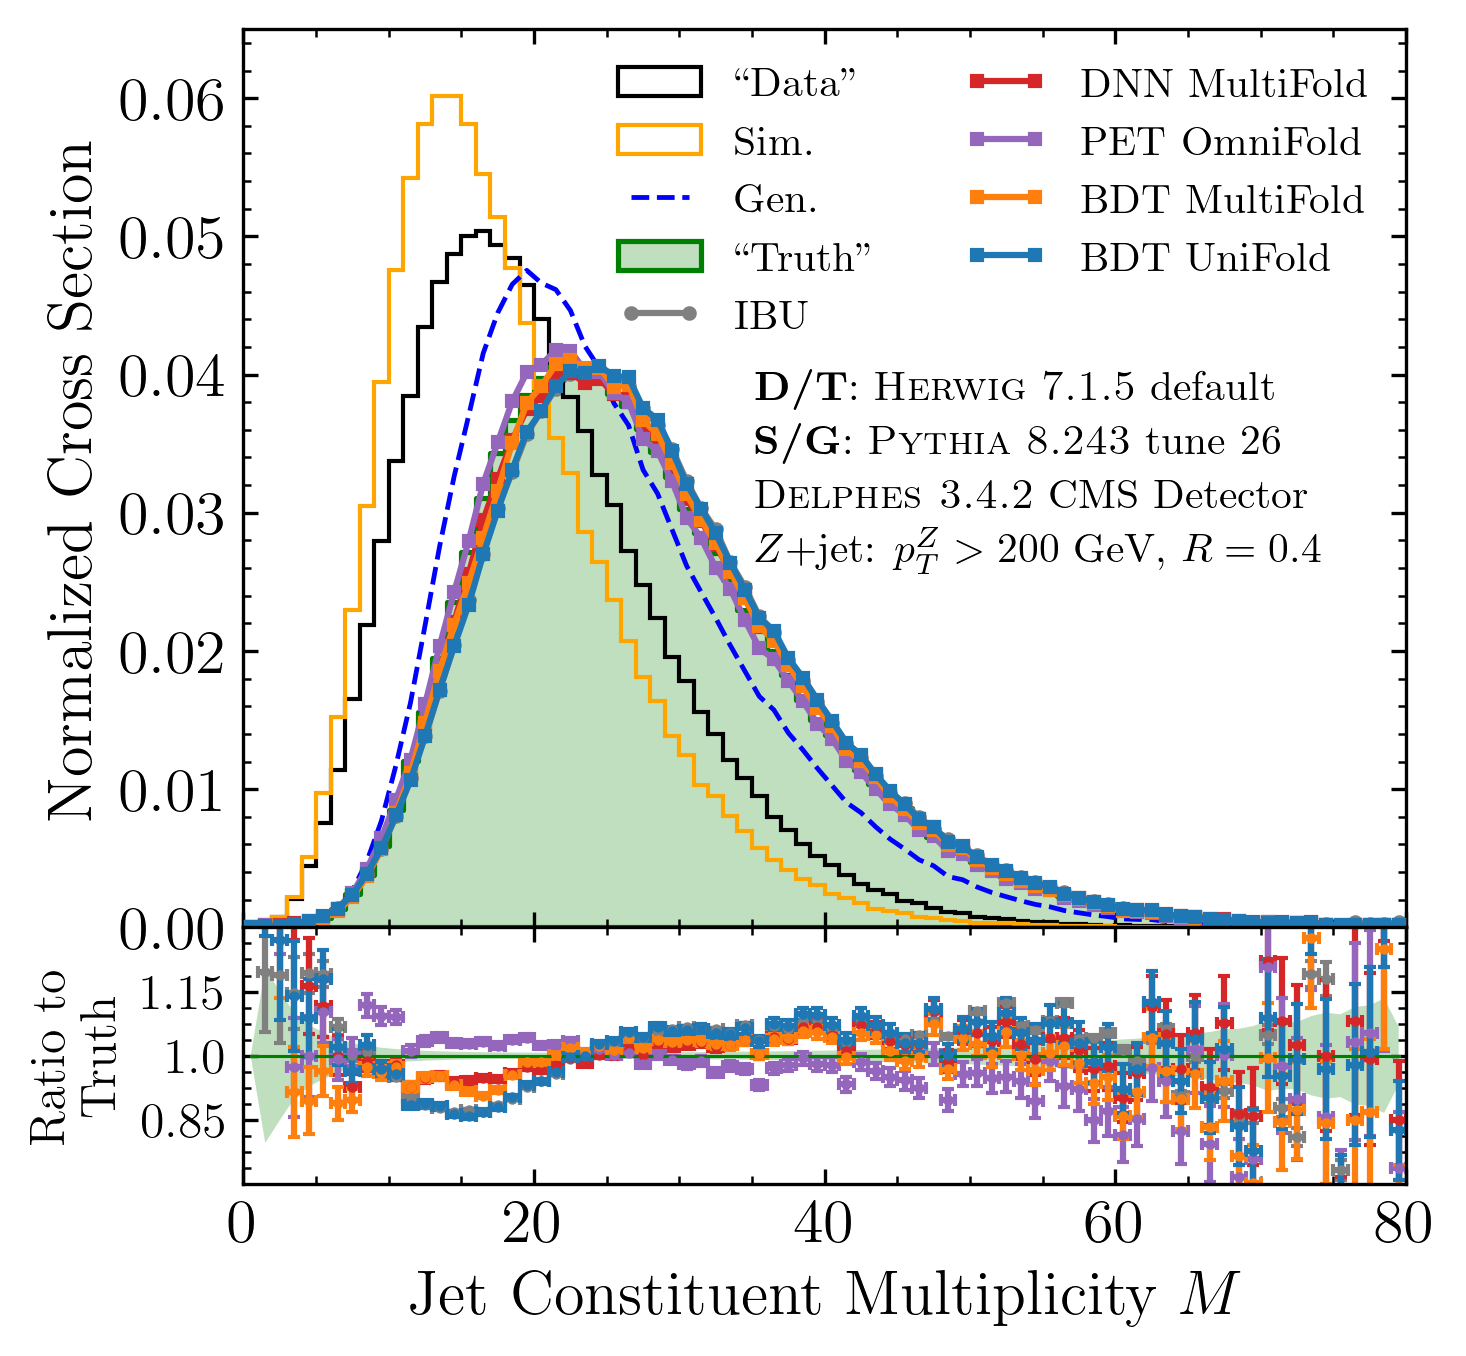

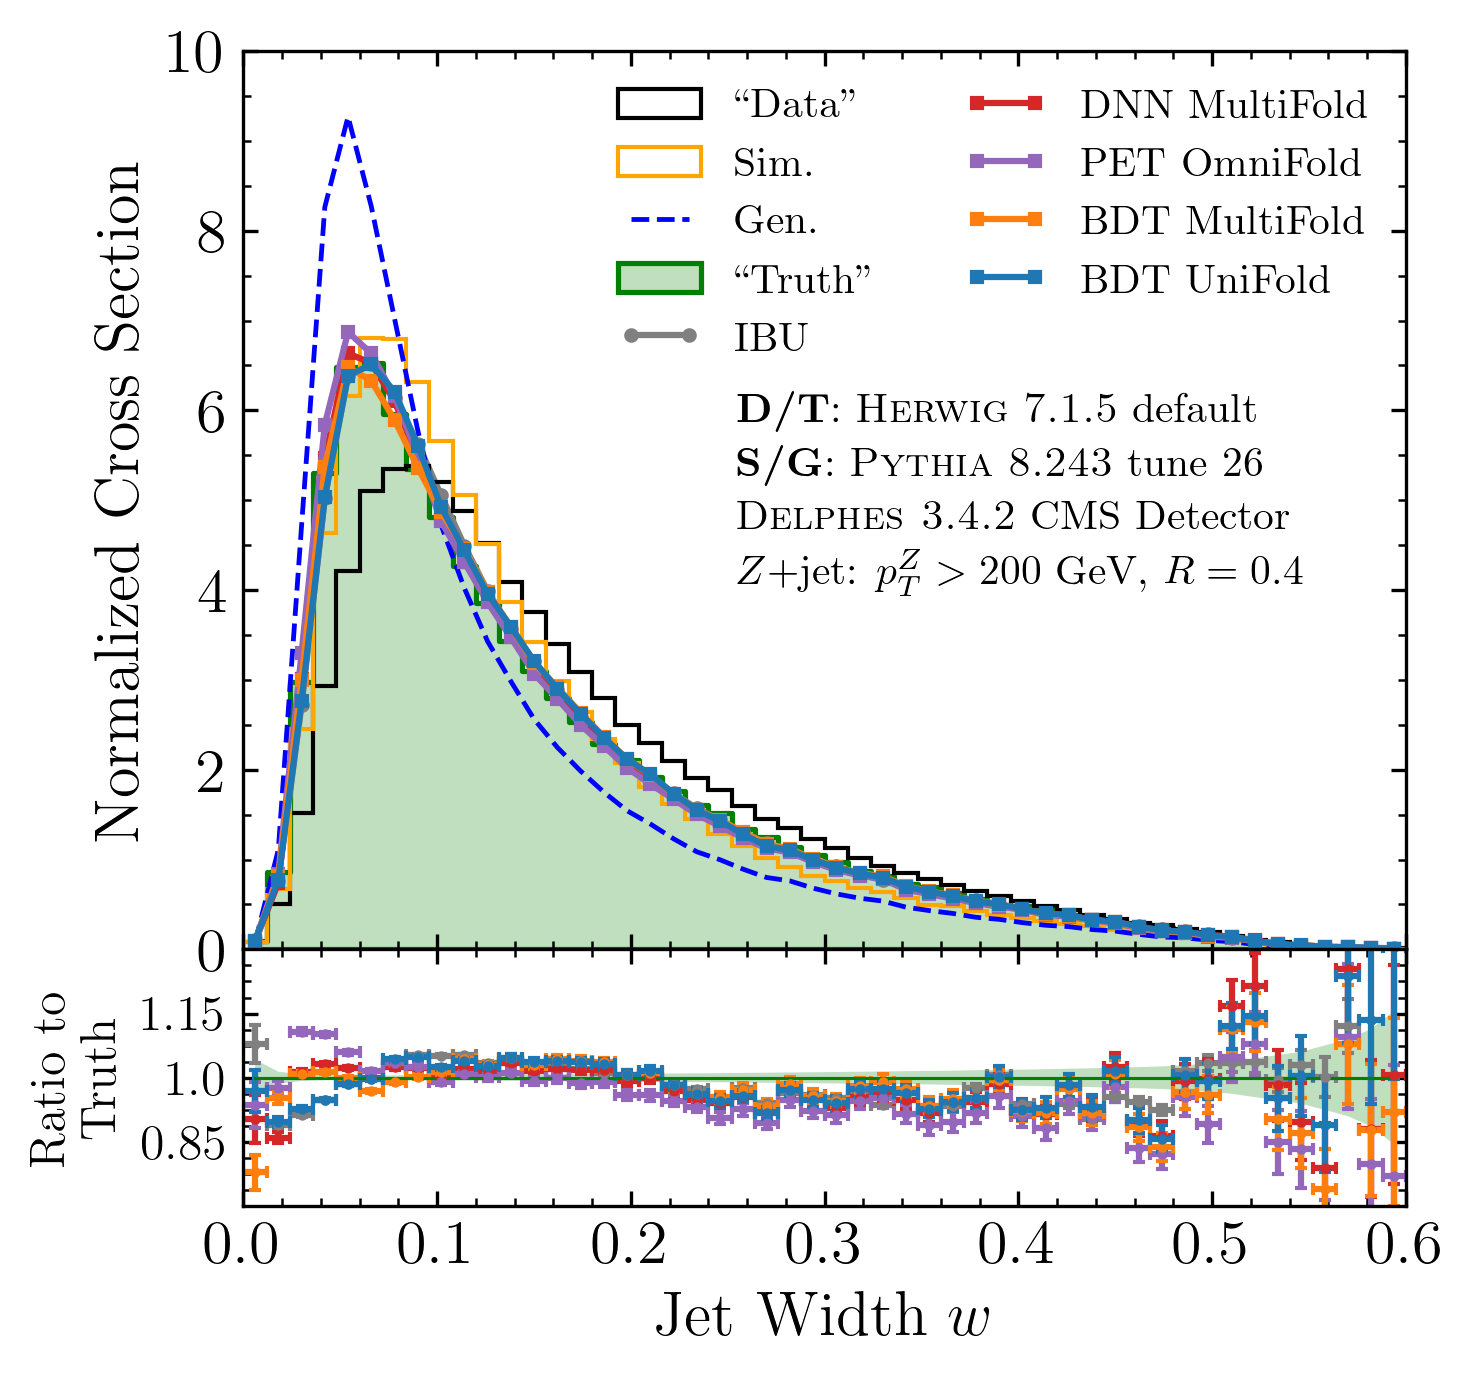

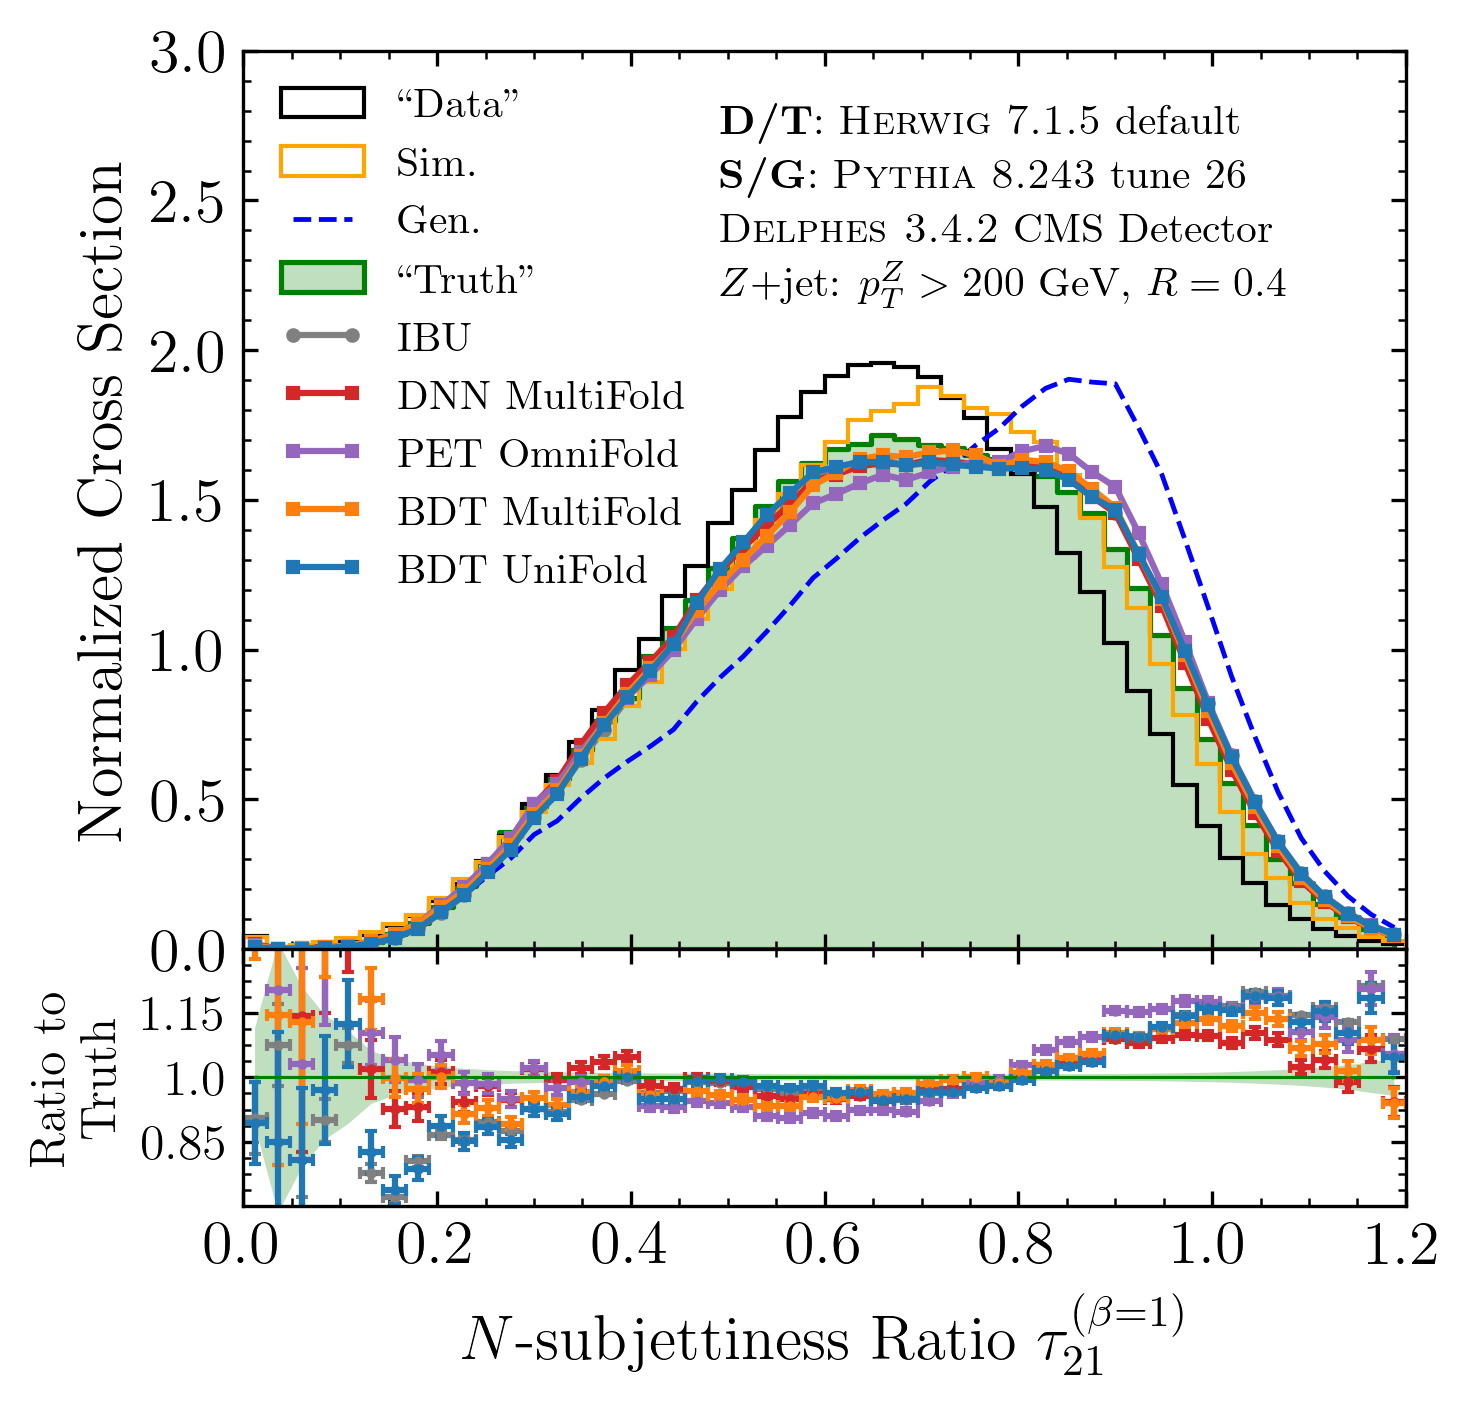

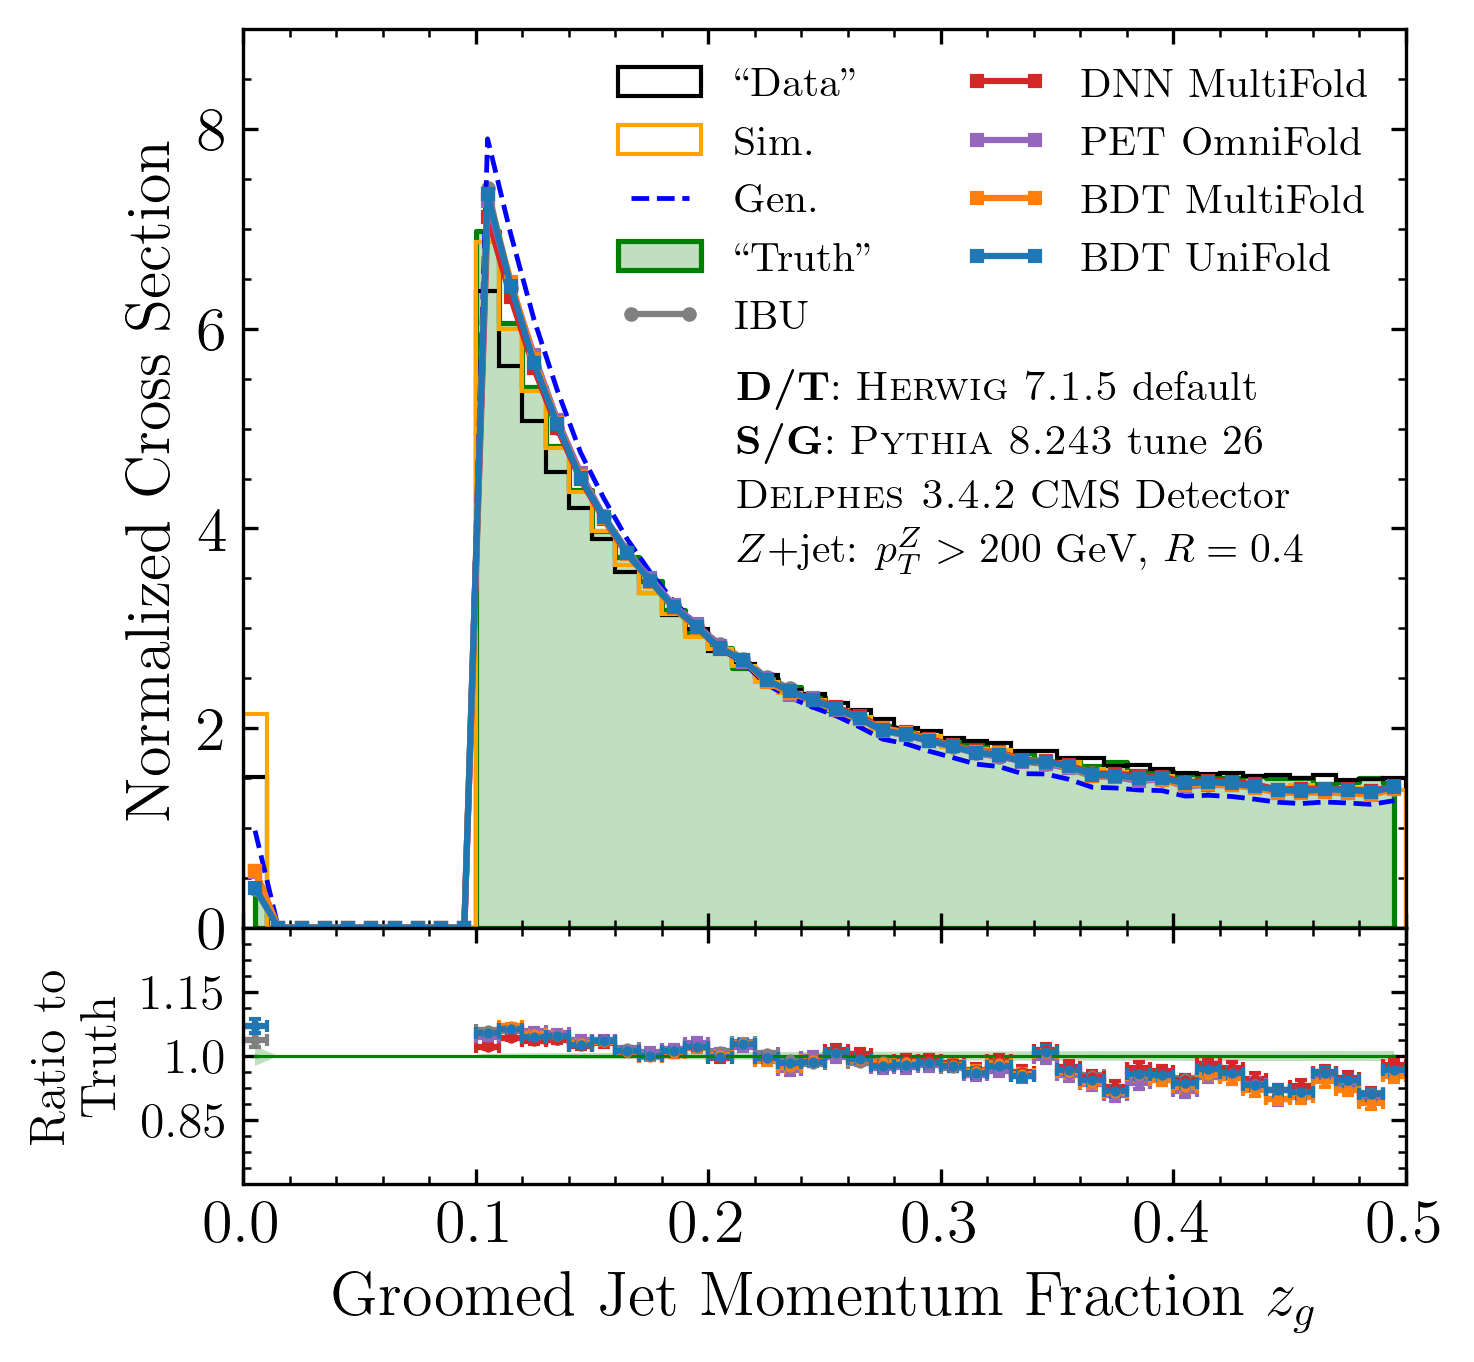

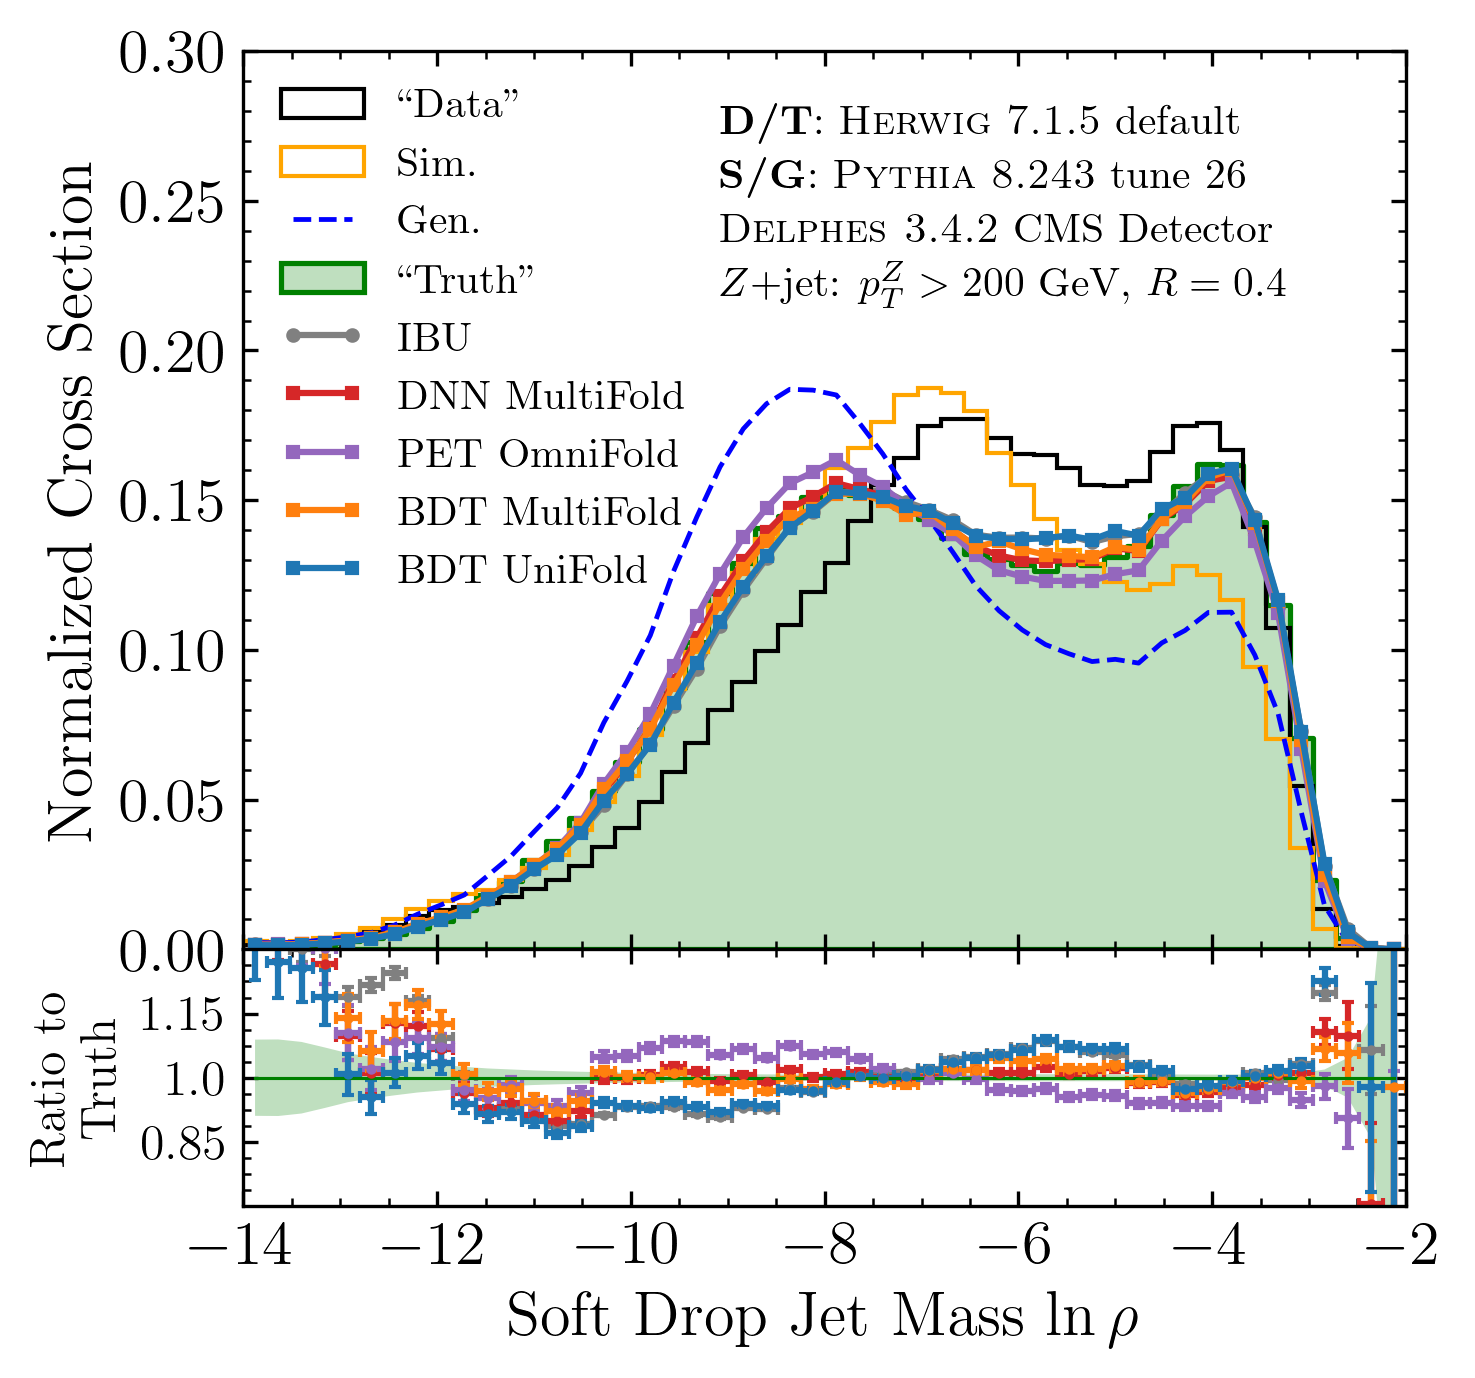

In [25]:
for i,(obkey,ob) in enumerate(obs_test.items()):
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob, figsize=(5,5))
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])
    if obkey=="Mass":
        ax0.yaxis.label.set_size(12.5)
    # Plot the Different Distributions of the Observable
    if draw_data: 
        ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='``Data\"', **hist_style)
    if draw_sim:
        ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style)
    if draw_mc:
        ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)
    if draw_truth:
        ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)
        
    # plot the IBU distribution
    if draw_IBU:
        ax0.plot(ob['ibu_bincenters'], ob['ibu'], **ibu_style, label='IBU')
        # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
        ibu_ratio = ob['ibu'] / (ob['truth_hist'] + 10**-50)
        ibu_unc_ratio = ob['ibu_unc'] / (ob['truth_hist'] + 10**-50)

        ax1.errorbar(
            ob['ibu_bincenters'], 
            ibu_ratio, 
            xerr=(ob['ibu_bincenters'][1]-ob['ibu_bincenters'][0])/2, 
            yerr=ibu_unc_ratio,                       
            color=ibu_style['color'], 
            **modplot.style('errorbar')
        )
    hist_range_low, hist_range_high = ob['xlim'][0], ob['xlim'][1]

    if draw_DNN:
        ob['histgen_DNN'], ob['histgen_DNN_errors'] = modplot.calc_hist(
            ob['genobs'], 
            weights = DNN_step2_weights, 
            bins=ob['bins_mc'], 
            hist_range = (hist_range_low, hist_range_high),
            density=True
        )[:2]
        ax0.plot(ob['midbins_mc'], ob['histgen_DNN'], **dnn_style, label='DNN MultiFold')
        DNN_ratio = ob['histgen_DNN'] /(ob['truth_hist'] + 10**-50)
        DNN_ratio_errors = ob['histgen_DNN_errors'] / (ob['truth_hist'] + 10**-50)
        
        ax1.errorbar(
            ob['midbins_mc'],
            DNN_ratio,
            xerr=ob['binwidth_mc']/2,
            yerr=DNN_ratio_errors,
            color=dnn_style['color'],  # Added comma here
            **modplot.style('errorbar')
        )
    if draw_PET:
        ob['histgen_PET'], ob['histgen_PET_errors'] = modplot.calc_hist(
            ob['genobs'], 
            weights=PET_step2_weights, 
            bins=ob['bins_mc'], 
            hist_range = (hist_range_low, hist_range_high),
            density=True
        )[:2]
        ax0.plot(ob['midbins_mc'], ob['histgen_PET'], **PET_style, label='PET OmniFold')

        PET_ratio = ob['histgen_PET'] /(ob['truth_hist'] + 10**-50)
        PET_ratio_errors = ob['histgen_PET_errors'] / (ob['truth_hist'] + 10**-50)
        
        ax1.errorbar(
            ob['midbins_mc'],
            PET_ratio,
            xerr=ob['binwidth_mc']/2,
            yerr=PET_ratio_errors,
            color=PET_style['color'],  # Added comma here
            **modplot.style('errorbar')
        )
        
    if draw_multifold_BDT:
        ob['histgen_multifold_BDT'], ob['histgen_multifold_BDT_errors'] = modplot.calc_hist(
            ob['genobs'], 
            weights=multifold_bdt_step2_weights,        
            bins=ob['bins_mc'], 
            hist_range = (hist_range_low, hist_range_high),
            density=True
        )[:2]
        ax0.plot(ob['midbins_mc'], ob['histgen_multifold_BDT'], **bdt_multifold_style, label='BDT MultiFold')

        multifold_BDT_ratio = ob['histgen_multifold_BDT'] /(ob['truth_hist'] + 10**-50)
        multifold_BDT_ratio_errors = ob['histgen_multifold_BDT_errors'] / (ob['truth_hist'] + 10**-50)
        
        ax1.errorbar(
            ob['midbins_mc'],
            multifold_BDT_ratio,
            xerr=ob['binwidth_mc']/2,
            yerr=multifold_BDT_ratio_errors,
            color=bdt_multifold_style['color'],
            **modplot.style('errorbar')
        )
        
    if draw_unifold_BDT:
        ob['histgen_unifold_BDT'], ob['histgen_unifold_BDT_errors'] = modplot.calc_hist(
            ob['genobs'], 
            weights=unifold_bdt_step2_weights[i], 
            bins=ob['bins_mc'],
            hist_range = (hist_range_low, hist_range_high),
            density=True
        )[:2]
        ax0.plot(ob['midbins_mc'], ob['histgen_unifold_BDT'], **bdt_unifold_unbinned_style, label='BDT UniFold')
        
        unifold_BDT_ratio = ob['histgen_unifold_BDT'] /(ob['truth_hist'] + 10**-50)
        unifold_BDT_ratio_errors = ob['histgen_unifold_BDT_errors'] / (ob['truth_hist'] + 10**-50)
        
        ax1.errorbar(
            ob['midbins_mc'],
            unifold_BDT_ratio,
            xerr=ob['binwidth_mc']/2,
            yerr=unifold_BDT_ratio_errors,
            color=bdt_unifold_unbinned_style['color'],  # Added comma here
            **modplot.style('errorbar')
        )
    
    if draw_binned_BDT:
        ax0.plot(ob['binned_BDT_bincenters'], ob['binned_BDT'], **ibu_style, label='IBU')
        # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
        binned_IBU_ratio = ob['binned_BDT'] / (ob['truth_hist'] + 10**-50)
        binned_IBU_unc_ratio = ob['binned_BDT_unc'] / (ob['truth_hist'] + 10**-50)

        ax1.errorbar(
            ob['binned_BDT_bincenters'], 
            binned_IBU_ratio, 
            xerr=(ob['binned_BDT_bincenters'][1]-ob['binned_BDT_bincenters'][0])/2, 
            yerr=binned_IBU_unc_ratio,                       
            color=bdt_binned_style['color'], 
            **modplot.style('errorbar')
        )
    

    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc'] / (ob['truth_hist'] + 10**-50)
    if truth_fill:
        ax1.fill_between(
            ob['midbins_mc'], 
            1 - truth_unc_ratio, 
            1 + truth_unc_ratio,          
            facecolor=truth_style['facecolor'], 
            zorder=-2
        )

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    modplot.legend(ax=ax0, frameon=False, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'\textbf{D/T}: \textsc{Herwig 7.1.5} default',
                  line_1=r'\textbf{S/G}: \textsc{Pythia 8.243} tune 26',
                  line_2=r'\textsc{Delphes 3.4.2} CMS Detector',
                  line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')

    fig.savefig(f'./final_plots/OmniFold_{obkey}_150pT_cut_BDTRooUnfold_5iterations.pdf', bbox_inches='tight')
    plt.show()

### Plotting binned BDT and IBU

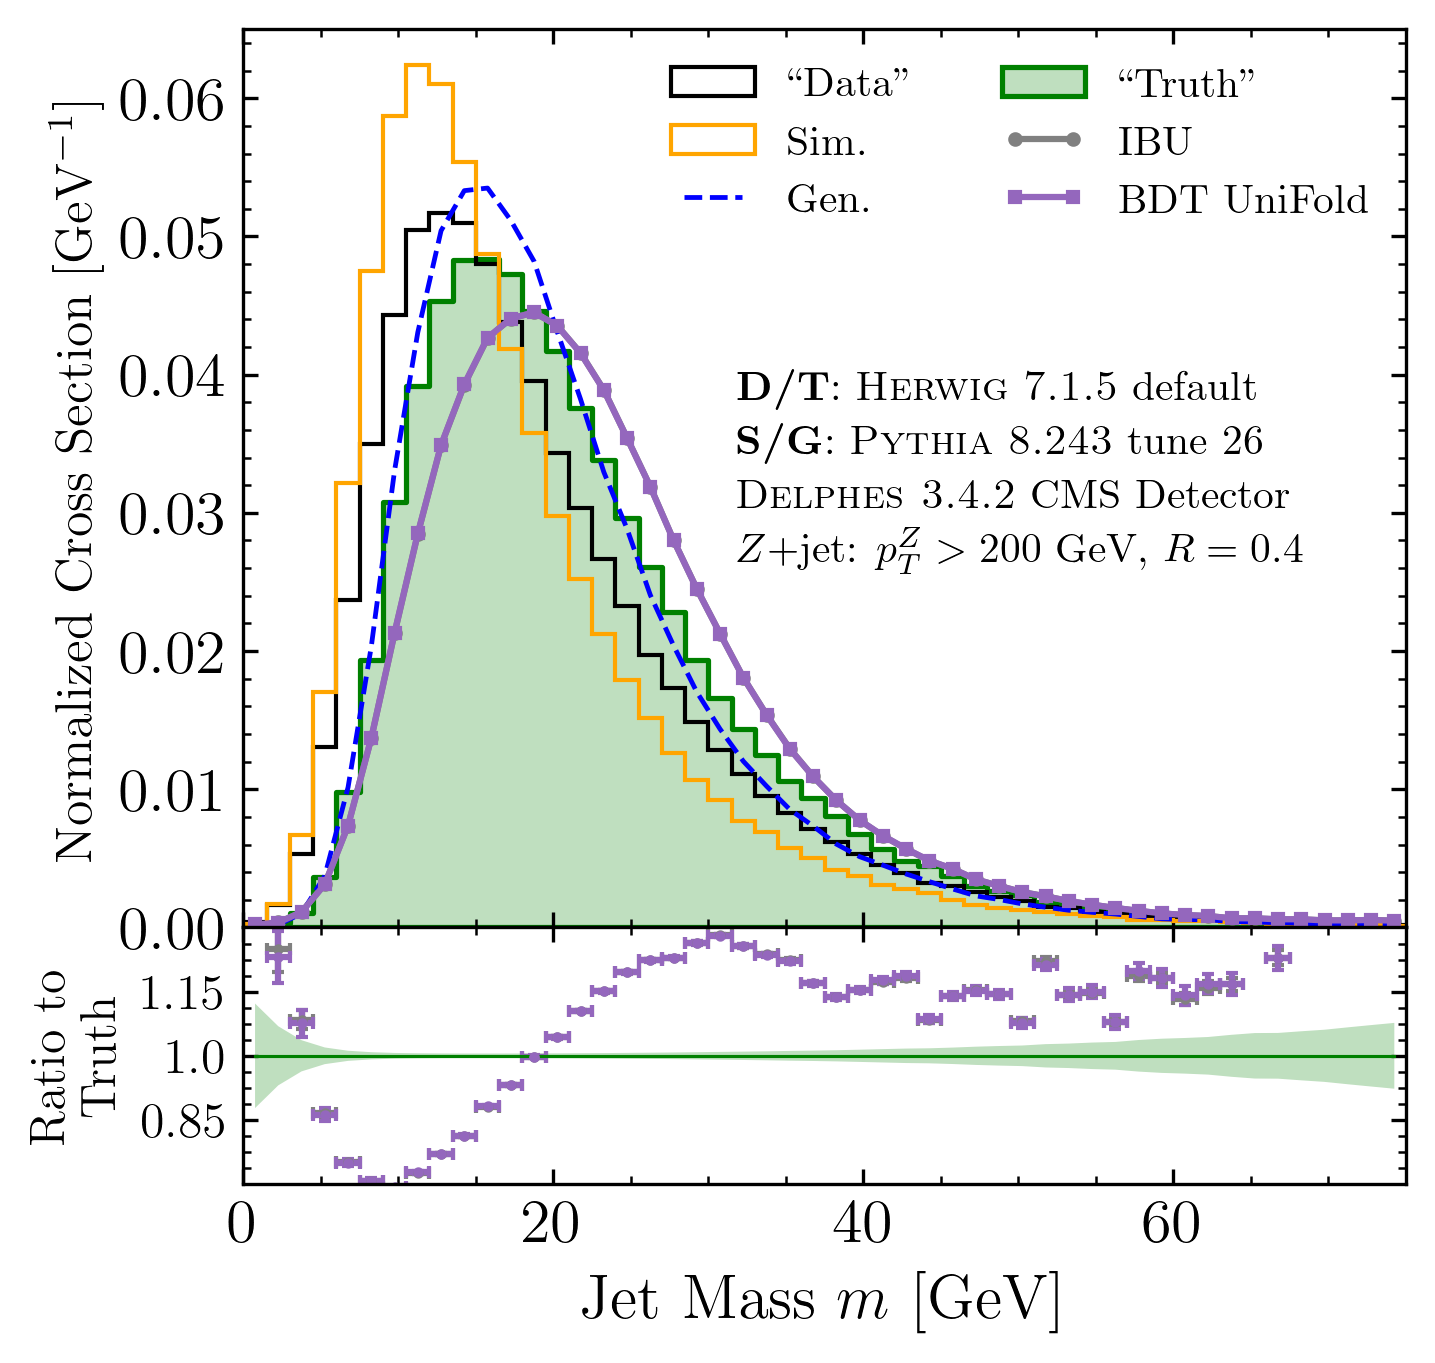

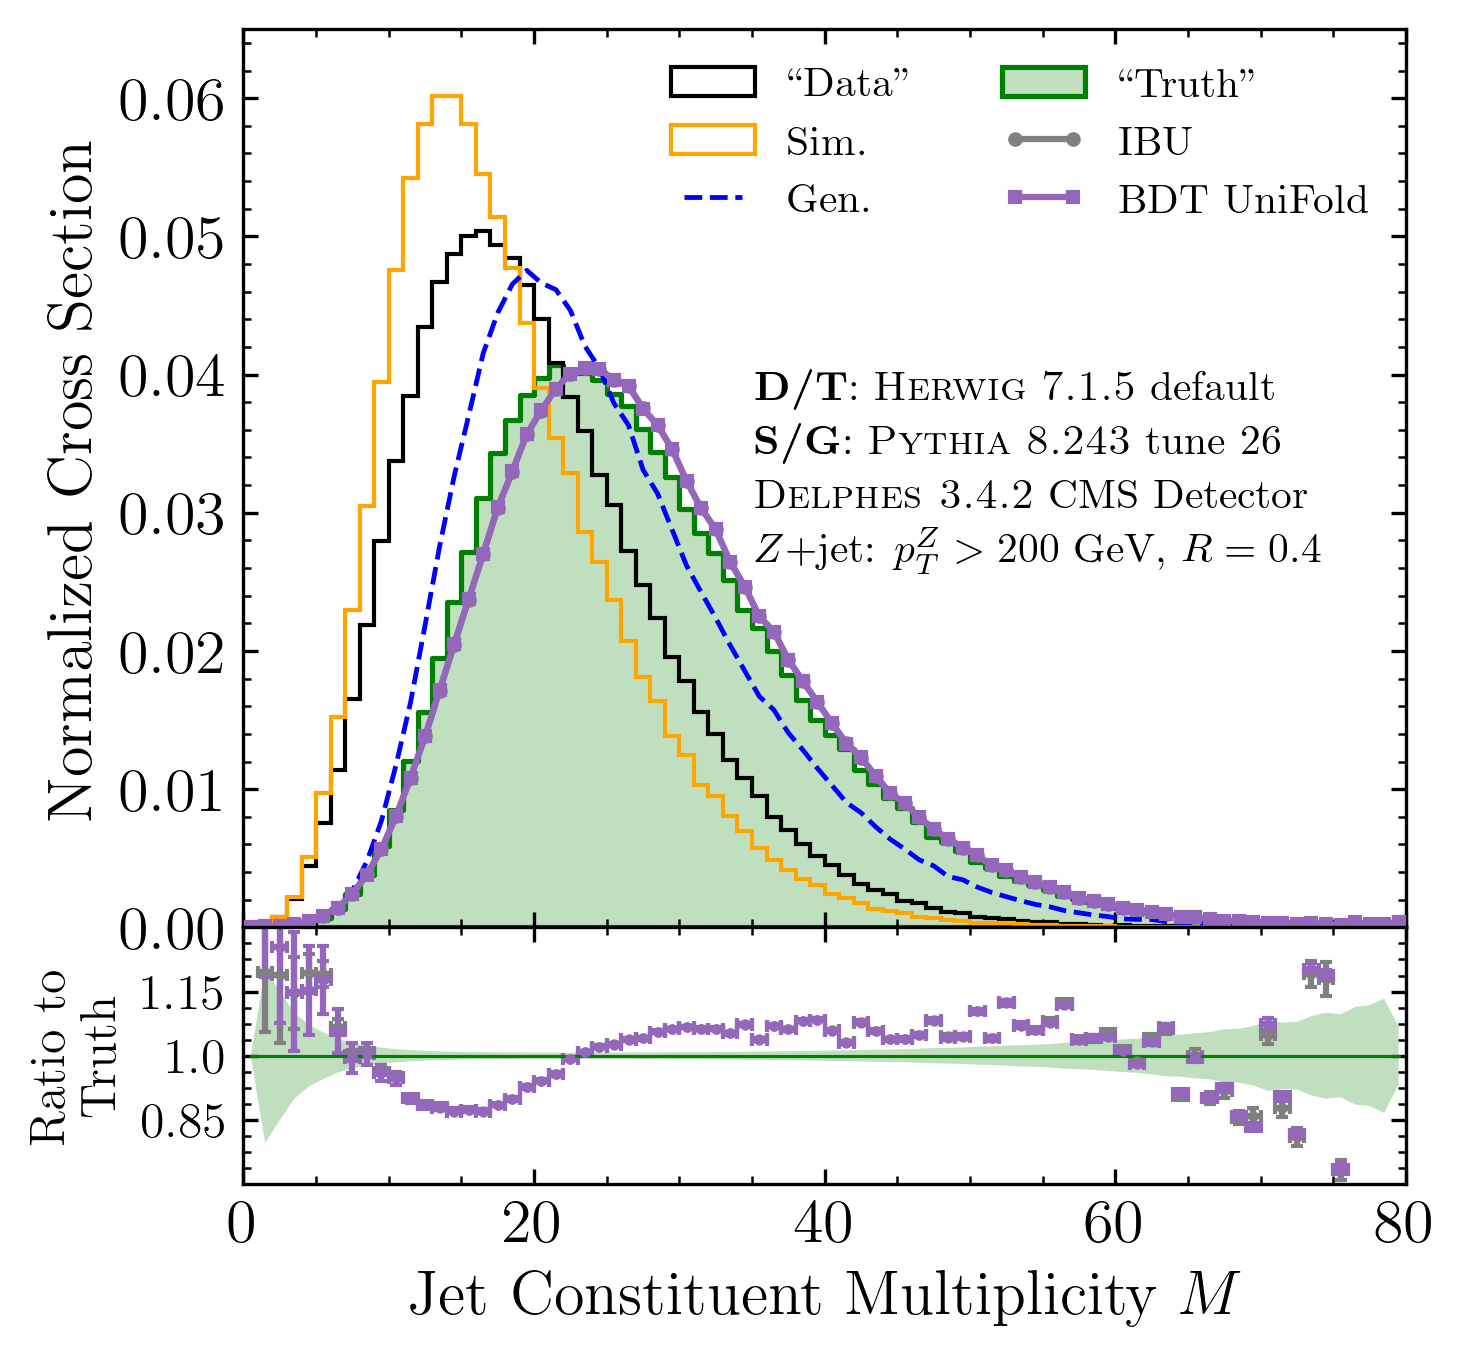

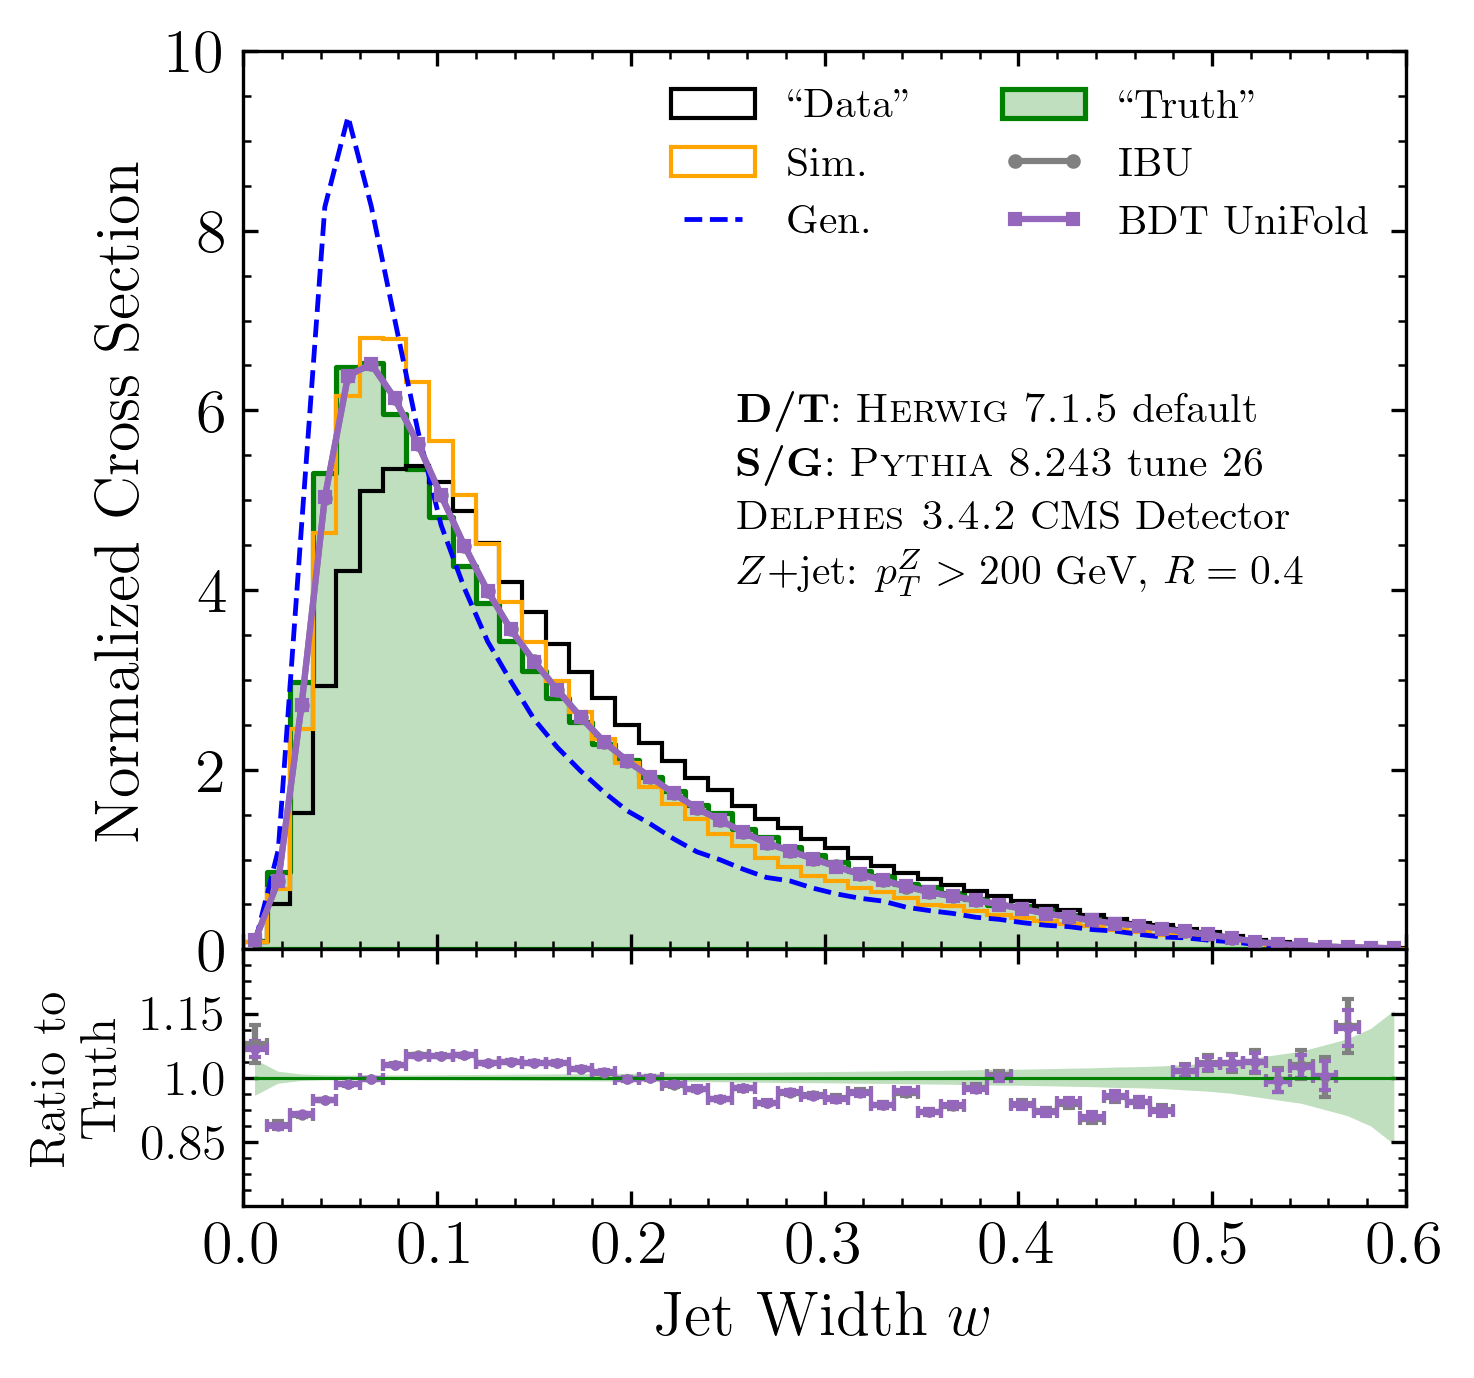

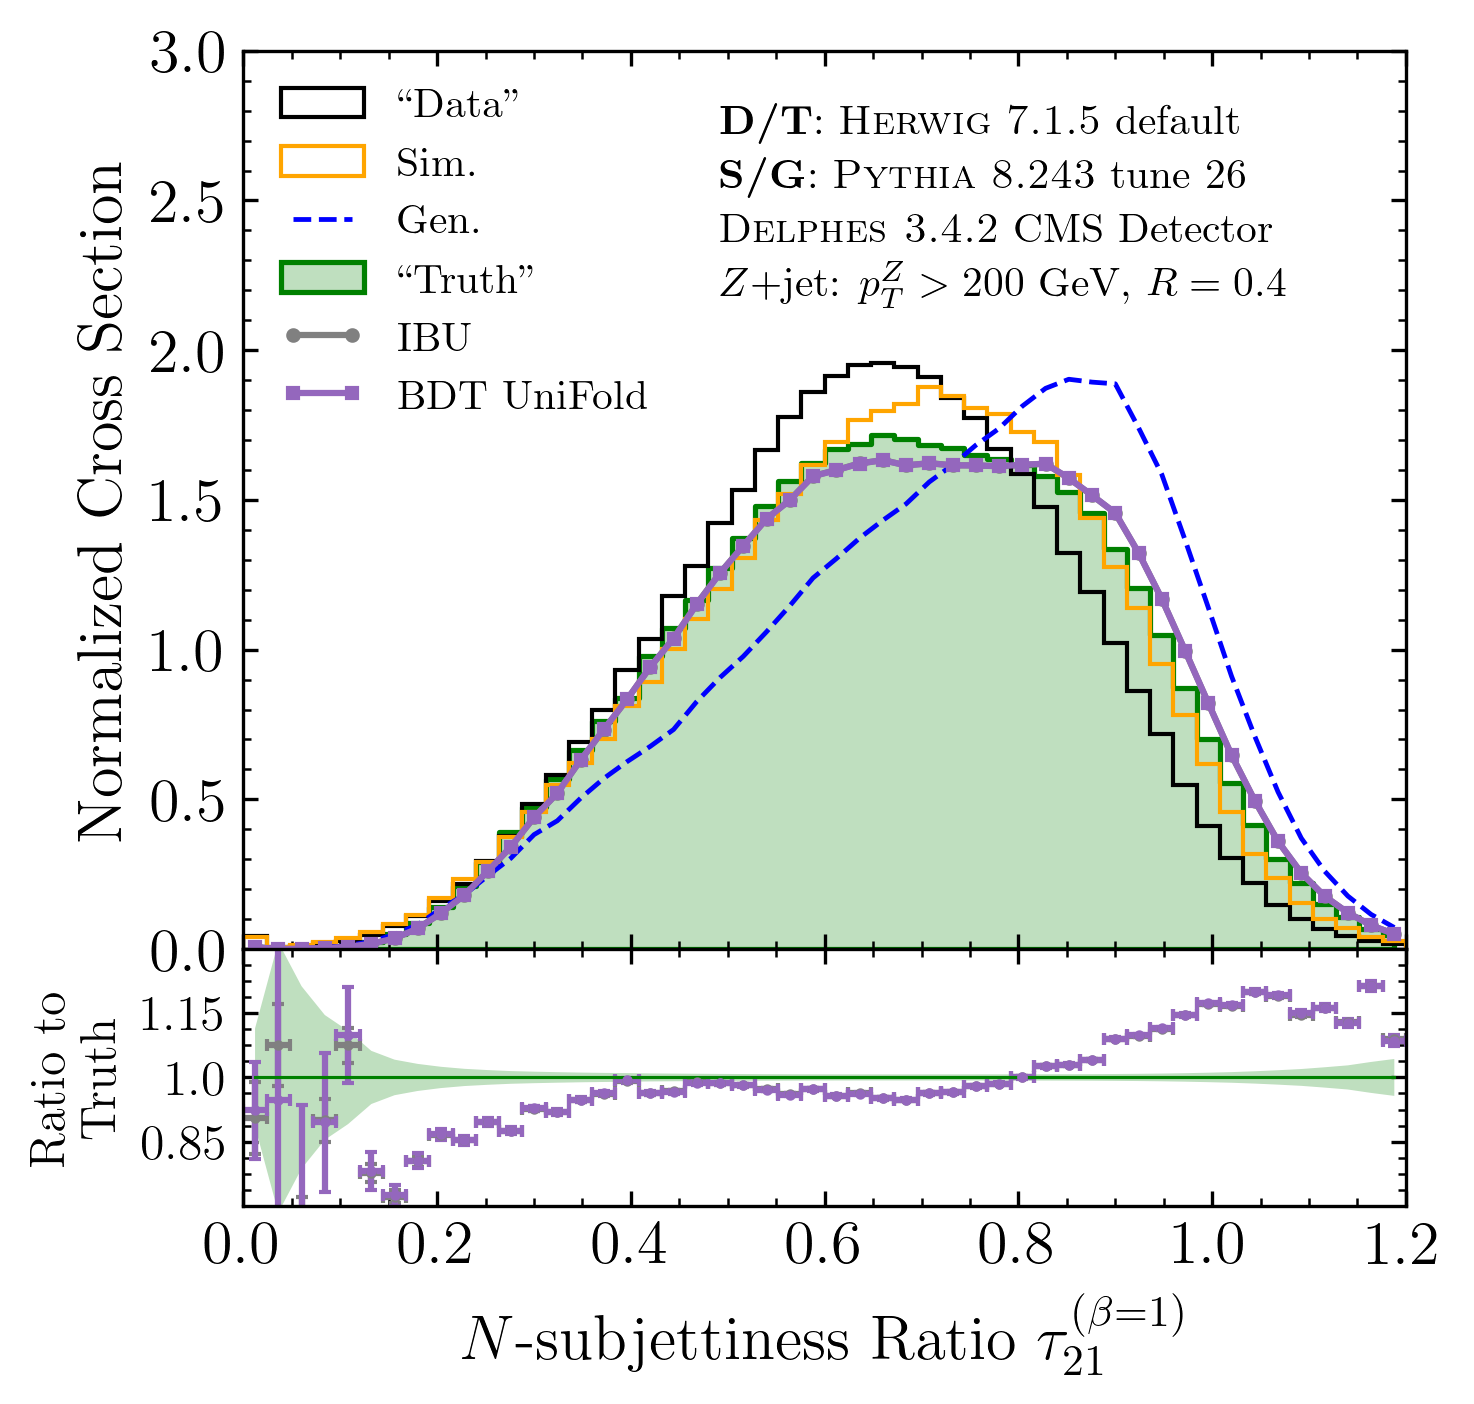

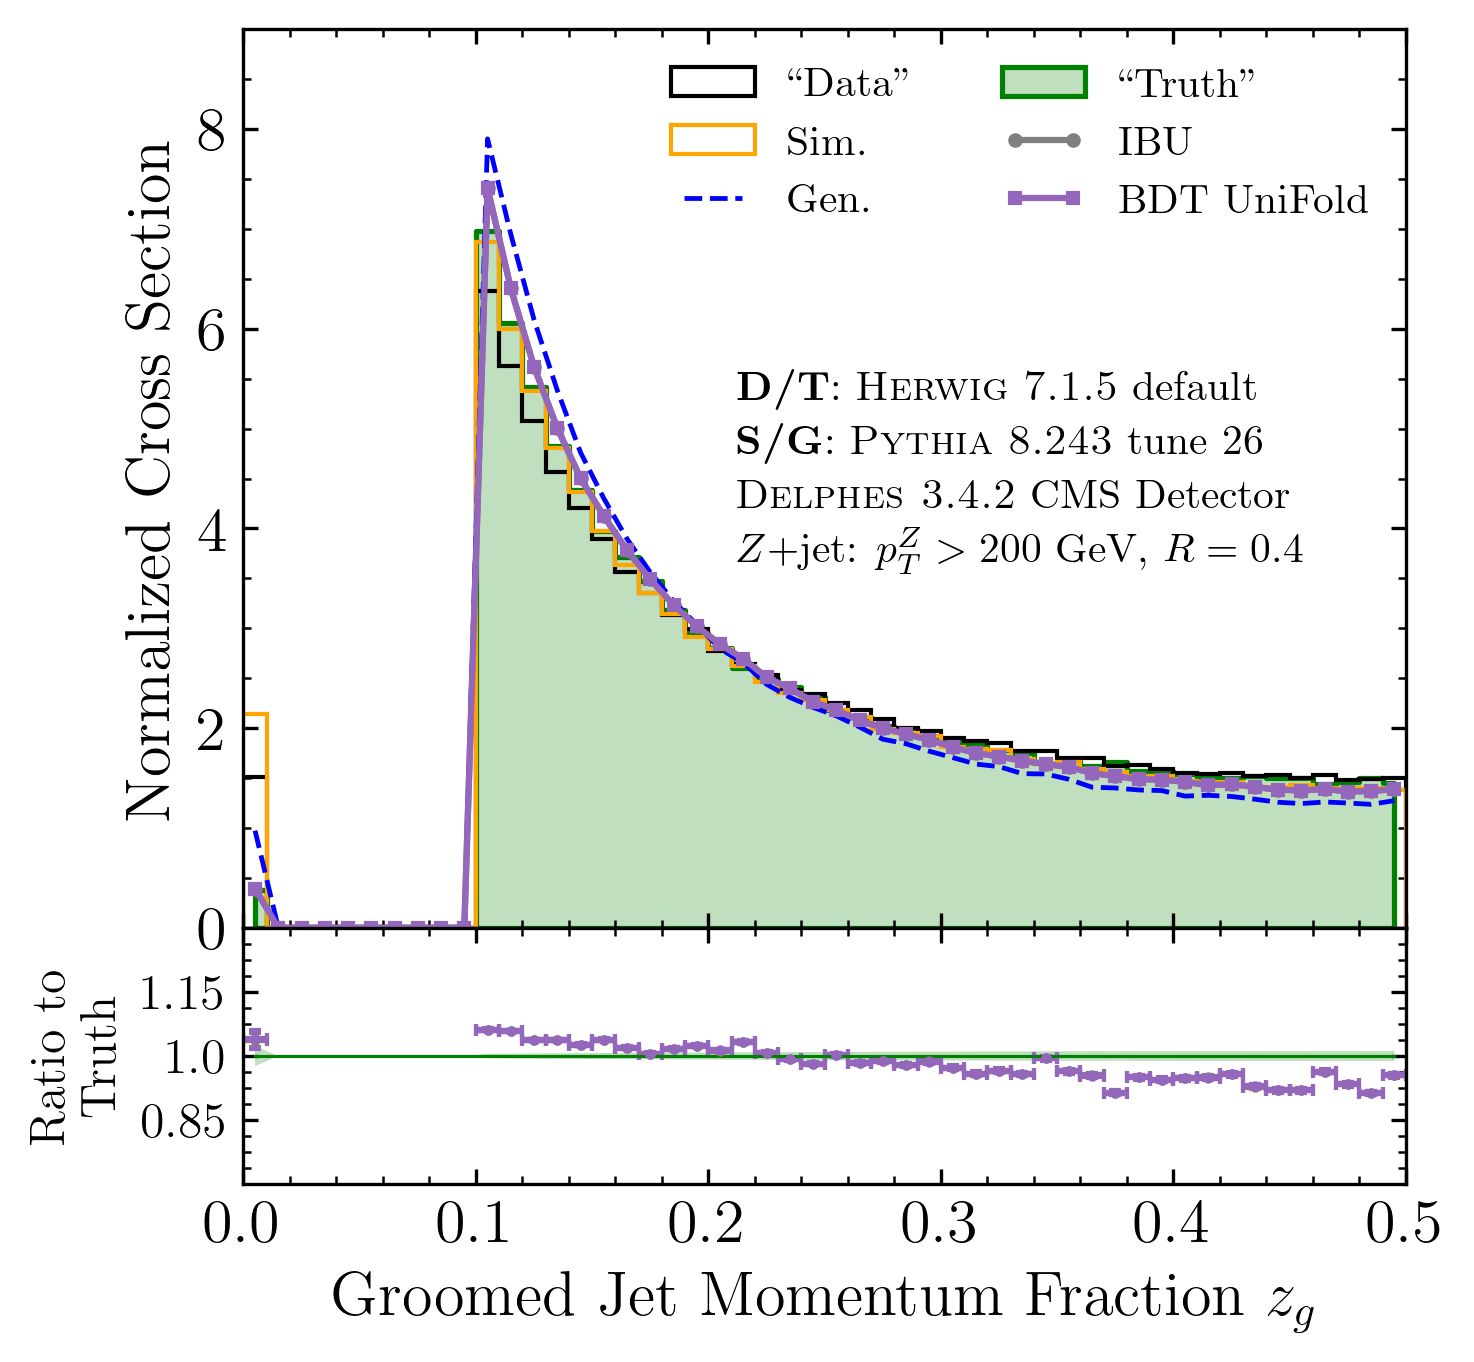

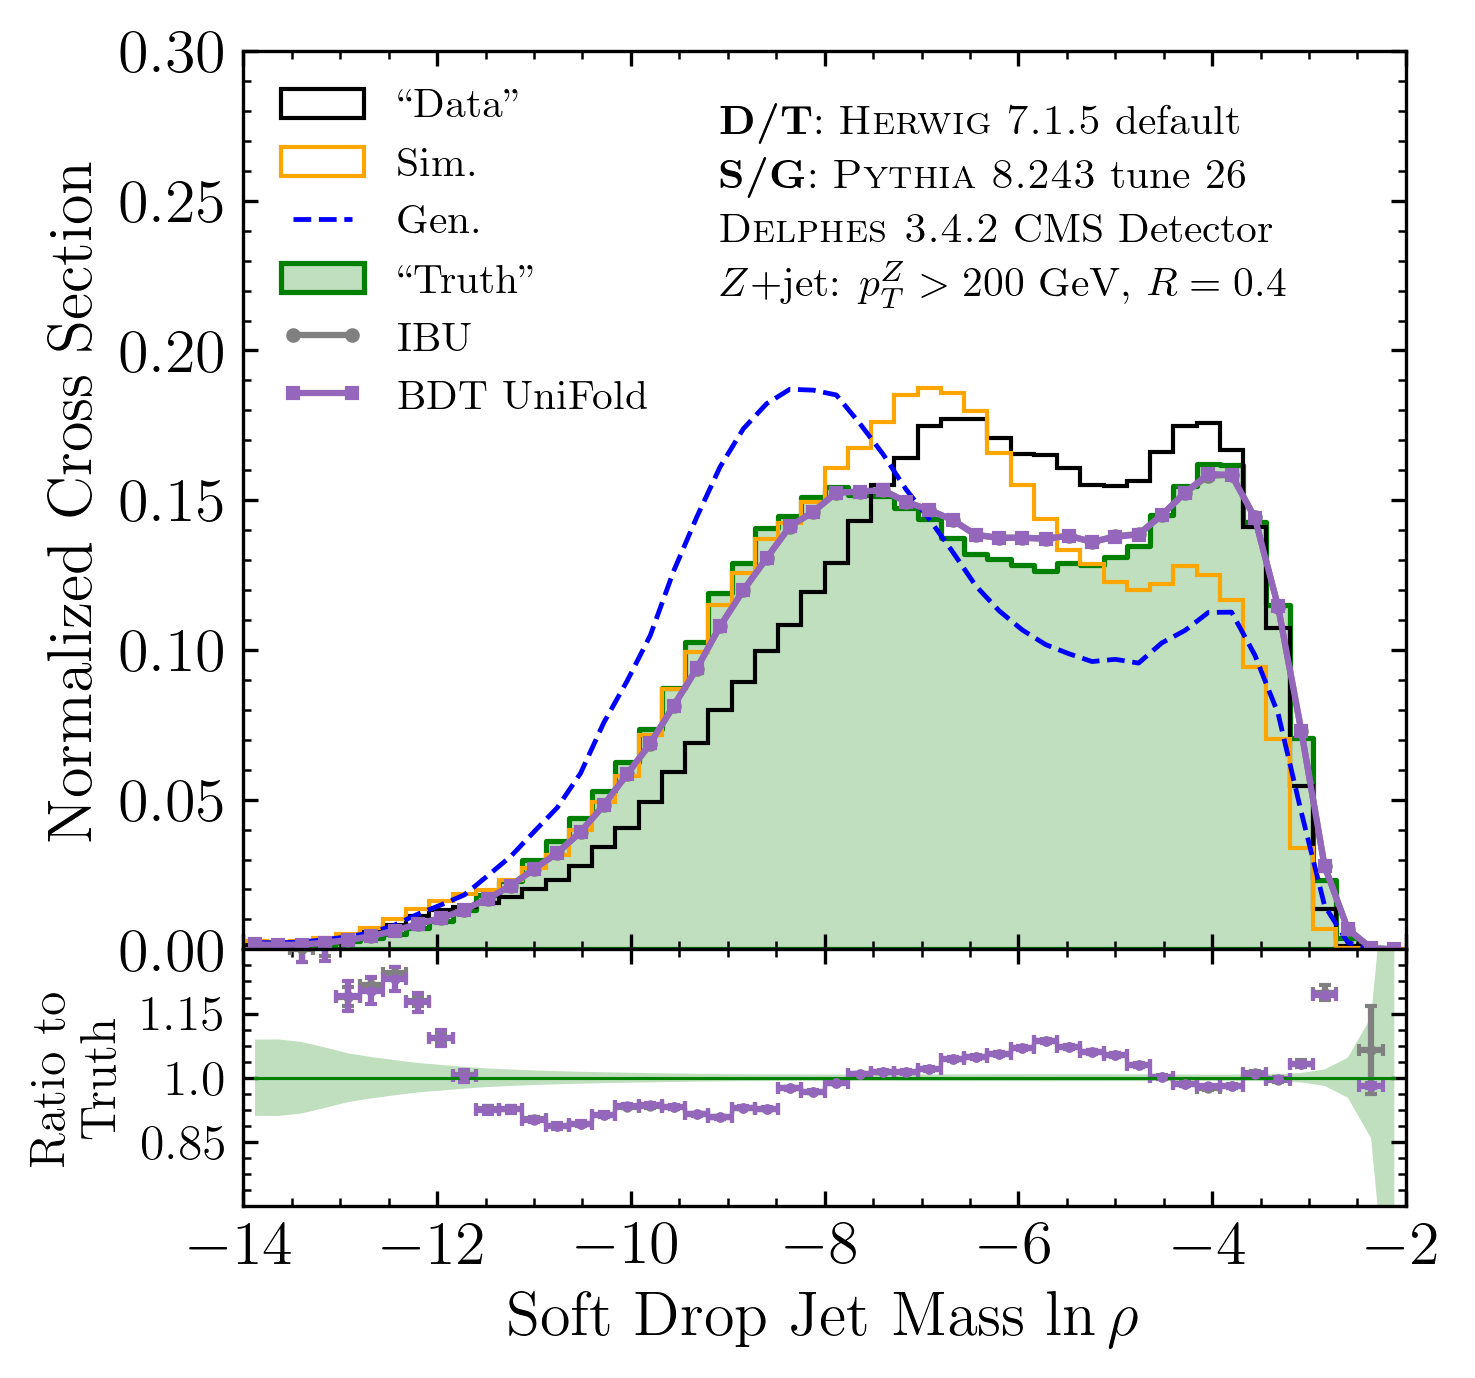

In [26]:
if use_binned_BDT:
    for i,(obkey,ob) in enumerate(obs_test.items()):
        # get the styled axes on which to plot
        fig, [ax0, ax1] = modplot.axes(**ob, figsize=(5,5))
        if ob.get('yscale') is not None:
            ax0.set_yscale(ob['yscale'])
        if obkey=="Mass":
            ax0.yaxis.label.set_size(12.5)
        # Plot the Different Distributions of the Observable
        if draw_data: 
            ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='``Data\"', **hist_style)
        if draw_sim:
            ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style)
        if draw_mc:
            ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)
        if draw_truth:
            ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)
            
        # plot the IBU distribution
        ax0.plot(ob['ibu_bincenters'], ob['ibu'], **ibu_style, label='IBU')
        # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
        ibu_ratio = ob['ibu'] / (ob['truth_hist'] + 10**-50)
        ibu_unc_ratio = ob['ibu_unc'] / (ob['truth_hist'] + 10**-50)
    
        ax1.errorbar(
            ob['ibu_bincenters'], 
            ibu_ratio, 
            xerr=(ob['ibu_bincenters'][1]-ob['ibu_bincenters'][0])/2, 
            yerr=ibu_unc_ratio,                       
            color=ibu_style['color'], 
            **modplot.style('errorbar')
        )
        ax0.plot(ob['binned_BDT_bincenters'], ob['binned_BDT'], **bdt_binned_style, label='BDT UniFold')
        # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
        binned_IBU_ratio = ob['binned_BDT'] / (ob['truth_hist'] + 10**-50)
        binned_IBU_unc_ratio = ob['binned_BDT_unc'] / (ob['truth_hist'] + 10**-50)
    
        ax1.errorbar(
            ob['binned_BDT_bincenters'], 
            binned_IBU_ratio, 
            xerr=(ob['binned_BDT_bincenters'][1]-ob['binned_BDT_bincenters'][0])/2, 
            yerr=binned_IBU_unc_ratio,                       
            color=bdt_binned_style['color'], 
            **modplot.style('errorbar')
        )
    
    
        ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
        
        # ratio uncertainties
        truth_unc_ratio = ob['truth_hist_unc'] / (ob['truth_hist'] + 10**-50)
        if truth_fill:
            ax1.fill_between(
                ob['midbins_mc'], 
                1 - truth_unc_ratio, 
                1 + truth_unc_ratio,          
                facecolor=truth_style['facecolor'], 
                zorder=-2
            )
    
        # legend style and ordering
        loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
        modplot.legend(ax=ax0, frameon=False, loc=loc, ncol=ncol)
    
        # stamp to put on the plots
        modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                      line_0=r'\textbf{D/T}: \textsc{Herwig 7.1.5} default',
                      line_1=r'\textbf{S/G}: \textsc{Pythia 8.243} tune 26',
                      line_2=r'\textsc{Delphes 3.4.2} CMS Detector',
                      line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')
    
        fig.savefig(f'./final_plots/OmniFold_{obkey}_150pT_cut_binnedvsIBU_BDTRooUnfold_5iterations.pdf', bbox_inches='tight')
        plt.show()

### Calculating metric

In [27]:
def calculate_triangle_distance(data, binning, truth, data_weights=None):
    truth_weights = np.ones(len(truth))
    bin_widths = np.abs(binning[1] - binning[0])
    
    x, _ = np.histogram(truth, weights=truth_weights, bins=binning)
    x2,_ = np.histogram(truth, weights=truth_weights**2, bins=binning)
    
    x_norm = np.sum(x)*bin_widths

    if data_weights is None:
        data_weights = np.ones(len(data))
    y, _ = np.histogram(data, weights=data_weights, bins=binning)
    y2, _ = np.histogram(data, weights=data_weights**2, bins=binning)
    y_norm = np.sum(y)*bin_widths
    
    dist = sum(0.5 * bin_widths*(x[ib] / x_norm - y[ib] / y_norm) ** 2 / (x[ib] / x_norm + y[ib] / y_norm)
               if x[ib]+ y[ib] > 0 else 0.0 for ib in range(len(x)))

    return dist * 1e3

In [28]:
triangular_discriminator_results = {}

# Iterate through each observable in obs.items()
for i, (obkey, ob) in enumerate(obs_test.items()):
    if 'truth_hist' in ob:
        truth_hist = ob['truth_hist']
        # Dictionary to store triangular discriminator values for this observable
        discriminator_values = {}
        if use_PET:
            discriminator_values['\\textsc{OmniFold} PET'] = np.round(calculate_triangle_distance(data = ob['genobs'], binning = ob['bins_mc'], truth = ob['truthobs'], data_weights=PET_step2_weights),2)
        if use_DNN:
            discriminator_values['\\textsc{MultiFold} DNN'] = np.round(calculate_triangle_distance(data = ob['genobs'], binning = ob['bins_mc'], truth = ob['truthobs'], data_weights=DNN_step2_weights),2)
        if use_multifold_BDT:
            discriminator_values['\\textsc{MultiFold} BDT'] = np.round(calculate_triangle_distance(data = ob['genobs'], binning = ob['bins_mc'], truth = ob['truthobs'], data_weights=multifold_bdt_step2_weights),2)
        if use_unifold_BDT:
            discriminator_values['\\textsc{UniFold} BDT'] = np.round(calculate_triangle_distance(data = ob['genobs'], binning = ob['bins_mc'], truth = ob['truthobs'], data_weights=multifold_bdt_step2_weights),2)

        discriminator_values['IBU'] = np.round(calculate_triangle_distance(data =  ob['midbins_mc'], data_weights = ob['ibu'], binning = ob['bins_mc'], truth=ob['truthobs']),2)
        discriminator_values['Data'] = np.round(calculate_triangle_distance(data = ob['dataobs'], binning = ob['bins_mc'], truth = ob['truthobs']),2)
        discriminator_values['Generation'] = np.round(calculate_triangle_distance(data = ob['genobs'], binning = ob['bins_mc'], truth = ob['truthobs']),2)
        
        # Add the results for this observable (obkey) to the main results dictionary
        triangular_discriminator_results[obkey] = discriminator_values

        
# Convert the results dictionary to a DataFrame
df_triangular = pd.DataFrame(triangular_discriminator_results)
# Display the DataFrame
df_triangular.reset_index(inplace=True)

# Rename the current 'index' column to 'discriminator'
df_triangular.rename(columns={'index': 'Model name'}, inplace=True)

# Set 'discriminator' as the index
df_triangular.set_index('Model name', inplace=True)
df_triangular = df_triangular[['Mass', 'Mult', 'Width', 'SDMass', 'Tau21', 'zg']]
df_triangular.round(2)
print(df_triangular)
latex_table = df_triangular.to_latex(index=True, escape=False,  float_format="%.2f")
print(latex_table)

                         Mass    Mult  Width  SDMass  Tau21    zg
Model name                                                       
\textsc{OmniFold} PET    0.79    0.42   0.81    0.66   1.97  0.74
\textsc{MultiFold} DNN   2.38    0.46   0.35    0.20   0.63  0.47
\textsc{MultiFold} BDT   2.64    0.53   0.31    0.22   0.92  0.74
\textsc{UniFold} BDT     2.64    0.53   0.31    0.22   0.92  0.74
IBU                      9.74    1.46   0.48    0.89   1.15  0.45
Data                    24.59  129.92  15.87   14.70  11.12  3.86
Generation               3.46   14.94  22.39   18.97  20.70  3.99
\begin{tabular}{lrrrrrr}
\toprule
 & Mass & Mult & Width & SDMass & Tau21 & zg \\
Model name &  &  &  &  &  &  \\
\midrule
\textsc{OmniFold} PET & 0.79 & 0.42 & 0.81 & 0.66 & 1.97 & 0.74 \\
\textsc{MultiFold} DNN & 2.38 & 0.46 & 0.35 & 0.20 & 0.63 & 0.47 \\
\textsc{MultiFold} BDT & 2.64 & 0.53 & 0.31 & 0.22 & 0.92 & 0.74 \\
\textsc{UniFold} BDT & 2.64 & 0.53 & 0.31 & 0.22 & 0.92 & 0.74 \\
IBU & 9.74 & 1

In [29]:
if use_binned_BDT:
    triangular_discriminator_results = {}
    
    # Iterate through each observable in obs.items()
    for obkey, ob in obs_test.items():
        if 'truth_hist' in ob:
            truth_hist = ob['truth_hist']
            # Dictionary to store triangular discriminator values for this observable1000
            discriminator_values = {
                
                'Binned BDT': np.round(calculate_triangle_distance(data =  ob['midbins_mc'], data_weights = ob['binned_BDT'], binning = ob['bins_mc'], truth=ob['truthobs']),2),
                'IBU': np.round(calculate_triangle_distance(data =  ob['midbins_mc'], data_weights = ob['ibu'], binning = ob['bins_mc'], truth=ob['truthobs']),2),
                'Data': np.round(calculate_triangle_distance(data = ob['dataobs'], binning = ob['bins_mc'], truth = ob['truthobs']),2),
                'Generation': np.round(calculate_triangle_distance(data = ob['genobs'], binning = ob['bins_mc'], truth = ob['truthobs']),2),
            }
            
            # Add the results for this observable (obkey) to the main results dictionary
            triangular_discriminator_results[obkey] = discriminator_values
    
            
    # Convert the results dictionary to a DataFrame
    df_triangular = pd.DataFrame(triangular_discriminator_results)
    # Display the DataFrame
    df_triangular.reset_index(inplace=True)
    
    # Rename the current 'index' column to 'discriminator'
    df_triangular.rename(columns={'index': 'Model name'}, inplace=True)
    
    # Set 'discriminator' as the index
    df_triangular.set_index('Model name', inplace=True)
    df_triangular = df_triangular[['Mass', 'Mult', 'Width', 'SDMass', 'Tau21', 'zg']]
    df_triangular.round(2)
    print(df_triangular)
    latex_table = df_triangular.to_latex(index=True, escape=False,  float_format="%.2f")
    print(latex_table)

             Mass    Mult  Width  SDMass  Tau21    zg
Model name                                           
Binned BDT   9.69    1.43   0.47    0.87   1.16  0.45
IBU          9.74    1.46   0.48    0.89   1.15  0.45
Data        24.59  129.92  15.87   14.70  11.12  3.86
Generation   3.46   14.94  22.39   18.97  20.70  3.99
\begin{tabular}{lrrrrrr}
\toprule
 & Mass & Mult & Width & SDMass & Tau21 & zg \\
Model name &  &  &  &  &  &  \\
\midrule
Binned BDT & 9.69 & 1.43 & 0.47 & 0.87 & 1.16 & 0.45 \\
IBU & 9.74 & 1.46 & 0.48 & 0.89 & 1.15 & 0.45 \\
Data & 24.59 & 129.92 & 15.87 & 14.70 & 11.12 & 3.86 \\
Generation & 3.46 & 14.94 & 22.39 & 18.97 & 20.70 & 3.99 \\
\bottomrule
\end{tabular}

